In [1]:
import numpy as np
import pickle
from scipy import signal
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import copy
import matplotlib.pyplot as plt
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
import scipy.signal as signal
import numpy as np
import pickle
from scipy import signal
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
label = pickle.load(open("labels.pkl", "rb" )).tolist()

In [3]:
label

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0]

In [4]:
output = pickle.load(open("data.pkl", "rb" ))
subjectlist = output["subjectlist"]
id = output["id"]
time_stamp_wearable = output["time_stamp_wearable"]
missing_subjectlist = output["missing_subjectlist"]
missing_time_stampslist = output["missing_time_stampslist"]
missing_featurelist = output["missing_featurelist"]
effective_subject_size = len(subjectlist)
extract_feature = output["extract_feature"]

In [5]:
long_chunks_start_time = []
long_chunks_end_time = []
for i in range(effective_subject_size):
    #print(i)
    cur_chunks_end_time = [] 
    cur_chunks_start_time = []
    cur_subject = subjectlist[i]
    cur_time_sampleSize = len(cur_subject)
    long_chunks = dict(zip(extract_feature, [[] for i in range(len(extract_feature))]))
    for j in range(cur_time_sampleSize):
        cur_time_sample = cur_subject[j]
        #for m in cur_time_sample:
        cur_chunks_end_time.append(cur_time_sample['EDA'][2])
        cur_chunks_start_time.append(cur_time_sample['EDA'][1])
    long_chunks_start_time.append(cur_chunks_start_time)
    long_chunks_end_time.append(cur_chunks_end_time)
    #long_chunks_list.append(long_chunks)
        

        


In [6]:
import pandas as pd

def time_indicator(n):
    data = pd.DataFrame()
    data['start'] = long_chunks_start_time[n]
    data['end'] = long_chunks_end_time[n]
    data['day'] = data['start'].apply(lambda x: x.day)

    index = pd.DatetimeIndex(data['start'])
    index = index.astype(np.int64)// 10**9
    data['start_unix'] = index
    index = pd.DatetimeIndex(data['end'])
    index = index.astype(np.int64)// 10**9
    data['end_unix'] = index

    data.groupby('day',as_index = False).count()['start_unix']

    cur_subject = subjectlist[n]
    cur_time_sampleSize = len(cur_subject)
    long_chunks = dict(zip(extract_feature, [[] for i in range(len(extract_feature))]))
    for m in extract_feature:
        long = []
        for j in range(cur_time_sampleSize):
            cur_time_sample = cur_subject[j]
            #for m in cur_time_sample:
            long.append(cur_time_sample[m][0])        
        long_chunks[m] =long

    # file 1
    time_indicator = []
    for i in range(cur_time_sampleSize):    
        time_eda = data['start_unix'].values[i]
        N = len(long_chunks['EDA'][i])//4 +time_eda
        x = np.arange(time_eda,N,1)
        time_indicator.append(x)

    con_indicatior = np.concatenate(time_indicator)        
    return data,con_indicatior

In [7]:
subject_time_indicator = []
data_arr = []
for i in range(effective_subject_size):
    data,indicator = time_indicator(i)
    data_arr.append(data)
    subject_time_indicator.append(indicator)

In [8]:
len(subject_time_indicator),len(subject_time_indicator[0])


(19, 609122)

In [9]:
timestampfun = lambda x: pd.Timestamp(x).to_pydatetime().strftime("%s")

In [10]:
n = 18
s = np.datetime64('2015-09-%sT11:00:00.000000000'%str(n))
df_split = pd.DataFrame()
df_split['time'] = [s]
index = pd.DatetimeIndex(df_split['time'])
index = index.astype(np.int64)// 10**9
df_split['time_unix'] = index

In [11]:
interval = 3600 * 2
n = int(24 * 3600/ interval)

split_start = []
split_end = []
start = index[0]
end = index[0] + interval
for i in range(n):
    split_start.append(start)
    split_end.append(end)
    start = start + interval
    end = end + interval

In [12]:
import datetime
#time.strftime(1497281700)
def unix_date(x):
    return datetime.datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')



In [13]:
df_split = pd.DataFrame()
df_split['start_unix'] = split_start
df_split['end_unix'] = split_end

df_split['start'] = df_split['start_unix'].apply(unix_date)

df_split['end'] = df_split['end_unix'].apply(unix_date)

In [14]:
df_split

,start_unix,end_unix,start,end
0,1442574000,1442581200,2015-09-18 11:00:00,2015-09-18 13:00:00
1,1442581200,1442588400,2015-09-18 13:00:00,2015-09-18 15:00:00
2,1442588400,1442595600,2015-09-18 15:00:00,2015-09-18 17:00:00
3,1442595600,1442602800,2015-09-18 17:00:00,2015-09-18 19:00:00
4,1442602800,1442610000,2015-09-18 19:00:00,2015-09-18 21:00:00
5,1442610000,1442617200,2015-09-18 21:00:00,2015-09-18 23:00:00
6,1442617200,1442624400,2015-09-18 23:00:00,2015-09-19 01:00:00
7,1442624400,1442631600,2015-09-19 01:00:00,2015-09-19 03:00:00
8,1442631600,1442638800,2015-09-19 03:00:00,2015-09-19 05:00:00
9,1442638800,1442646000,2015-09-19 05:00:00,2015-09-19 07:00:00


In [15]:
1442760790,1442736439

(1442760790, 1442736439)

In [16]:
names = ['HRV15-002', 'HRV15-003', 'HRV15-004', 'HRV15-005', 'HRV15-006', 'HRV15-007', 'HRV15-008', 'HRV15-009', 'HRV15-011', 'HRV15-012', 'HRV15-013',  'HRV15-017', 'HRV15-018', 'HRV15-019', 'HRV15-020', 'HRV15-021', 'HRV15-022', 'HRV15-023', 'HRV15-024']


In [17]:
long_chunks_list = [] 
for i in range(effective_subject_size):
    #print(i)
    cur_subject = subjectlist[i]
    cur_time_sampleSize = len(cur_subject)
    long_chunks = dict(zip(extract_feature, [[] for i in range(len(extract_feature))]))
    for j in range(cur_time_sampleSize):
        cur_time_sample = cur_subject[j]
        for m in cur_time_sample:
            long_chunks[m] = np.concatenate((long_chunks[m],cur_time_sample[m][0]))
    long_chunks_list.append(long_chunks)

In [18]:
def group(n):
    subject0 = pd.DataFrame()
    subject0['Timestamp'] = subject_time_indicator[n]
    lis = []
    for i in range(len(df_split)):
        
        m = subject0[subject0['Timestamp']>= df_split.start_unix[i]][subject0['Timestamp']<= df_split.end_unix[i]]
        sublis = [m.index[0],m.index[-1]]
        lis.append(sublis)
    return lis


In [19]:
len(subject_time_indicator[14])

586248

In [20]:
time_interval = []    # totally 18 subjects
for i in range(len(subject_time_indicator)):
    #print (i)
   
    a = group(i)
    #print (i)
    time_interval.append(a)

    
    

/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [21]:
time_interval

[[[339685, 346885],
  [346885, 354085],
  [354085, 359261],
  [359261, 366461],
  [366461, 373661],
  [373661, 380861],
  [380861, 388061],
  [388061, 393925],
  [393925, 401125],
  [401125, 408325],
  [408325, 415525],
  [415525, 421180]],
 [[341189, 348389],
  [348389, 353888],
  [353888, 361088],
  [361088, 368288],
  [368288, 375488],
  [375488, 381312],
  [381312, 388512],
  [388512, 395712],
  [395712, 402912],
  [402912, 408622],
  [408623, 415788],
  [415788, 422988]],
 [[336403, 343603],
  [343603, 350803],
  [350803, 356604],
  [356604, 363804],
  [363804, 371004],
  [371004, 378204],
  [378204, 384021],
  [384021, 391221],
  [391221, 398421],
  [398421, 405621],
  [405621, 411310],
  [411310, 418510]],
 [[342122, 349322],
  [349322, 356522],
  [356522, 362042],
  [362042, 369242],
  [369242, 376442],
  [376442, 383642],
  [383642, 389552],
  [389552, 396752],
  [396752, 403952],
  [403952, 411152],
  [411152, 417213],
  [417213, 424413]],
 [[334762, 341962],
  [341962, 34785

In [22]:
# time_interval = []    # totally 18 subjects
# for i in range(len(subject_time_indicator)):
#     #print (i)
#     if i == 4 or i ==17 or i ==18:
#         print (i)
#     else:
#         a = group(i)
#         #print (i)
#         time_interval.append(a)

    
    

## totally 19 subjects

In [23]:
# time_interval = []    # totally 18 subjects
# for i in range(len(subject_time_indicator)):
#     #print (i)
#     if i == 17 or i == 18:
#         print (i)
#     else:
#         a = group(i)
#         #print (i)
#         time_interval.append(a)

    
    

In [24]:
len(time_interval)

19

In [25]:
time_interval
group(1)

/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[341189, 348389],
 [348389, 353888],
 [353888, 361088],
 [361088, 368288],
 [368288, 375488],
 [375488, 381312],
 [381312, 388512],
 [388512, 395712],
 [395712, 402912],
 [402912, 408622],
 [408623, 415788],
 [415788, 422988]]

In [26]:
# long_chunks_list.remove(long_chunks_list[-1])
# label.remove(label[-1])
# long_chunks_list.remove(long_chunks_list[-1])
# label.remove(label[-1])
# long_chunks_list.remove(long_chunks_list[4])
# label.remove(label[4])

In [27]:
# names.remove(names[-1])
# names.remove(names[-1])
# names.remove(names[4])


In [28]:
#time_interval[-1][i][0],time_interval[-1][i][1]

In [29]:
import pandas as pd
def chunk(n):
    chunk_TEMP = []
    chunk_EDA = []
    chunk_HR = []
    for i in range(len(time_interval[n])):
        a = long_chunks_list[n]['TEMP'][time_interval[n][i][0]*4:time_interval[n][i][1]*4]
        chunk_TEMP.append(a)
        a = long_chunks_list[n]['EDA'][time_interval[n][i][0]*4:time_interval[n][i][1]*4]
        chunk_EDA.append(a)
        a = long_chunks_list[n]['HR'][time_interval[n][i][0]:time_interval[n][i][1]]
        chunk_HR.append(a)
    long_chunk = {'TEMP':chunk_TEMP,'EDA':chunk_EDA,'HR':chunk_HR}
    return long_chunk


## effective_subject_size = 19

In [30]:
long_chunk_all = []
effective_subject_size = 19
for i in range(effective_subject_size):
    long_chunk = chunk(i)
    long_chunk_all.append(long_chunk)

In [31]:
names[13]

'HRV15-019'

In [32]:
#long_chunk_all[-1]

In [33]:
def filtered(n):    
    for i in range(len(df_split)):
        s = pd.Series(long_chunk_all[n]['TEMP'][i])    
        long_chunk_all[n]['TEMP'][i] = list(s[s>34][s<45])  
        long_chunk_all[n]['EDA'][i] = pd.Series(long_chunk_all[n]['EDA'][i])[s[s>34][s<45].index].dropna().values
        long_chunk_all[n]['HR'][i] = pd.Series(long_chunk_all[n]['HR'][i])[s[s>34][s<45].index[::4]//4].dropna().values
#     long_chunk_all[n]['TEMP'][i].index = np.arange(len(long_chunk_all[n]['TEMP'][i]))
#     long_chunk_all[n]['EDA'][i].index = np.arange(len(long_chunk_all[n]['EDA'][i]))
#     long_chunk_all[n]['HR'][i].index = np.arange(len(long_chunk_all[n]['HR'][i]))
    return long_chunk_all[n]

In [34]:
filtered_all = []
for i in range(effective_subject_size):
    filtered_output = filtered(i)
    filtered_all.append(filtered_output)

In [35]:

# for j in range(effective_subject_size):
#     print (j)
#     a = []
#     for i in range(len(filtered_all[j])):
#         a.append(len(filtered_all[j]['HR'][i]))
#     print (sum(a))

In [36]:

for j in range(effective_subject_size):
    print (j)
    a = []
    for i in range(len(time_interval[0])):
        a.append(len(filtered_all[j]['HR'][i]))
    print (a)

0
[7200, 7200, 4565, 7200, 7096, 7200, 7200, 5834, 7200, 7200, 6171, 5098]
1
[6175, 4330, 7200, 7200, 7174, 5806, 7200, 7200, 7200, 5689, 7085, 7200]
2
[6622, 7200, 5255, 7200, 6185, 7200, 5495, 7200, 7200, 7200, 5237, 7200]
3
[6058, 7200, 5202, 7200, 7200, 5527, 5873, 7200, 7200, 7200, 5560, 7200]
4
[4400, 3280, 5294, 6713, 7044, 5210, 7200, 6817, 6861, 5867, 5978, 7200]
5
[7200, 7135, 4553, 7200, 7186, 5912, 7200, 7200, 7200, 7200, 3688, 6770]
6
[6511, 5868, 5552, 7200, 7112, 7200, 5318, 7200, 7200, 7200, 5424, 7200]
7
[6756, 6894, 6201, 3721, 7166, 7200, 7200, 5597, 7200, 7200, 7200, 4877]
8
[7200, 7200, 7200, 5736, 7200, 7200, 7200, 5477, 7079, 5364, 7200, 4610]
9
[5871, 6044, 6949, 5847, 7200, 7200, 7200, 5909, 7200, 7200, 7200, 5355]
10
[6843, 4573, 7200, 7200, 7200, 5896, 7200, 7200, 7200, 5326, 6959, 7200]
11
[6766, 5699, 6196, 7182, 5824, 6488, 5507, 7200, 7200, 7200, 4839, 7200]
12
[7200, 7200, 5749, 7132, 5293, 7200, 5229, 7200, 7200, 7200, 5734, 6014]
13
[5888, 4659, 3968, 

In [37]:
# effective_chunk_10000 = []
# for i in [1,2,5,7,11,12,15]:
#     effective_chunk_10000.append(filtered_all[i])

In [38]:
long_chunks_list_final = [] 
long_chunk_all = []
for i in range(effective_subject_size):
    #print(i)
    cur_subject = filtered_all[i]
    for j in range(len(cur_subject['EDA'])):
        cur_subject['EDA'][j] = cur_subject['EDA'][j][:]
        cur_subject['TEMP'][j] = cur_subject['TEMP'][j][:]
        cur_subject['HR'][j] = cur_subject['HR'][j][:]
    long_chunk_all.append(cur_subject)


In [39]:
long_chunks_list = []
for i in range(effective_subject_size):  
    long_chunks = dict(zip(extract_feature, [[] for i in range(len(extract_feature))]))
    for m in extract_feature:
        long_chunks[m] = np.concatenate(long_chunk_all[i][m])
    long_chunks_list.append(long_chunks)

In [40]:
len(long_chunks_list)
len(long_chunks_list[1]['EDA'])

317828

In [41]:
for i in range(len(long_chunks_list)):
    print (i)
    print (len(long_chunks_list[i]['HR']))

0
79164
1
79459
2
79194
3
78620
4
71864
5
78444
6
78985
7
77212
8
78666
9
79175
10
79997
11
77301
12
78351
13
64612
14
77368
15
71742
16
76947
17
75145
18
72844


In [42]:
for i in range(effective_subject_size):
    
    long_chunks_list[i]['HR'] = long_chunks_list[i]['HR'][:64000]
    long_chunks_list[i]['EDA'] = long_chunks_list[i]['EDA'][:256000]
    long_chunks_list[i]['TEMP'] = long_chunks_list[i]['TEMP'][:256000]


In [43]:
for i in range(len(long_chunks_list)):
    print (len(long_chunks_list[i]['HR']))

64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000
64000


In [44]:
#effective_subject_size = 19

hr_win =3000
fft_chunkslist = []
time_stamps = []
hopping_percent = 1/12
#n = 401
for i in range(effective_subject_size):
    cur_long_chunks = long_chunks_list[i]
    fft_chunks= dict.fromkeys(extract_feature)
    for m in cur_long_chunks:
        hz = subjectlist[i][0][m][3]
        #print(m)
        fft_size = hr_win*hz
        window_size =  hz*hr_win
        overlap_size = hopping_percent*window_size
        #nyq = window_size/2
        tmp = cur_long_chunks[m] - np.mean(cur_long_chunks[m])
        f,t,Zxx=signal.stft(tmp,nperseg=window_size,noverlap=overlap_size,nfft=fft_size)
        Zxx=np.abs(Zxx)
        time_stamps.append(Zxx.shape[1])
        fft_chunks[m] = [f,t,Zxx]
    fft_chunkslist.append(fft_chunks)
time_stamps = np.array(time_stamps)
print("STFT complete")

STFT complete


In [45]:
fft_chunks['HR'][2].shape


(1501, 25)

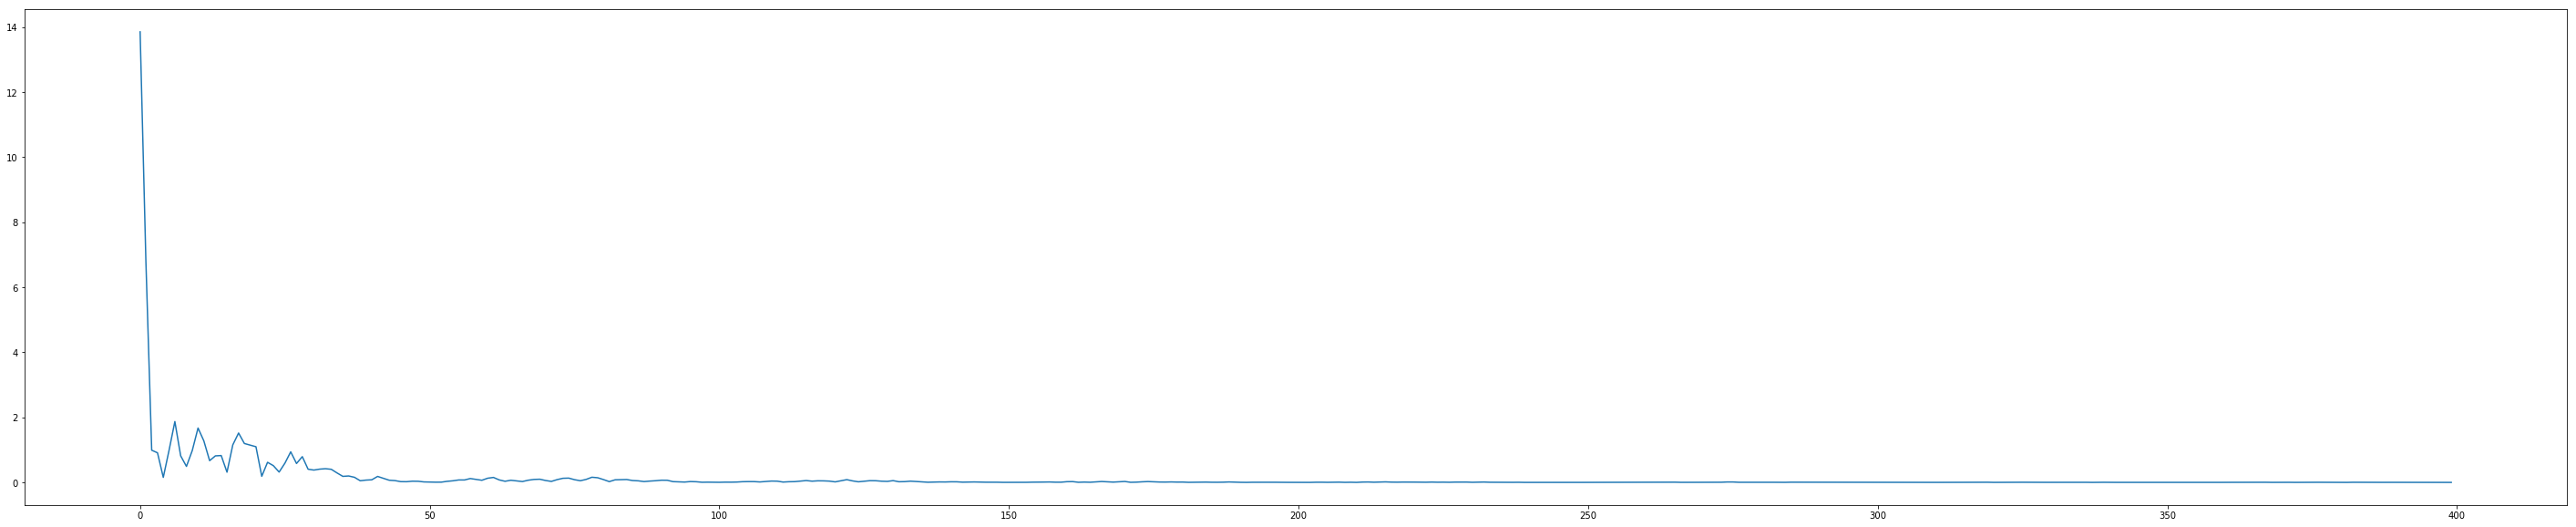

In [46]:
plt.figure(figsize=(50,10)) 

plt.plot(Zxx[:,1][:400])

In [47]:
Zxx[:,1][:]

array([  1.38584546e+01,   6.78957246e+00,   9.89922062e-01, ...,
         1.46510236e-04,   7.01794868e-05,   7.91723477e-05])

In [48]:
cut_hr  = 750
cur_tem = 3000

In [49]:
dtwlist = []
for i in range(effective_subject_size):
    print(i)
    cur_fft_chunks = fft_chunkslist[i]
    dtw = dict(zip(extract_feature, [[] for i in range(len(extract_feature))]))
    for m in cur_fft_chunks:
       # print(m)
        for j in range(1,cur_fft_chunks[m][2].shape[1]):
            if m == 'HR':
                tmpdtw,_ = fastdtw(cur_fft_chunks[m][2][:,0][:cut_hr][::2],cur_fft_chunks[m][2][:,j][:cut_hr][::2],dist=euclidean)
                dtw[m] = np.concatenate((dtw[m],np.array([tmpdtw])))
            else:
                tmpdtw,_ = fastdtw(cur_fft_chunks[m][2][:,0][:cur_tem][::8],cur_fft_chunks[m][2][:,j][:cur_tem][::8],dist=euclidean)
                dtw[m] = np.concatenate((dtw[m],np.array([tmpdtw])))
       
    dtwlist.append(dtw)          


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [50]:
names

['HRV15-002',
 'HRV15-003',
 'HRV15-004',
 'HRV15-005',
 'HRV15-006',
 'HRV15-007',
 'HRV15-008',
 'HRV15-009',
 'HRV15-011',
 'HRV15-012',
 'HRV15-013',
 'HRV15-017',
 'HRV15-018',
 'HRV15-019',
 'HRV15-020',
 'HRV15-021',
 'HRV15-022',
 'HRV15-023',
 'HRV15-024']

In [51]:
len(names),len(label)


(19, 19)

In [52]:
#date = ['18/09_12AM','21/09_12AM']
date = ['18/09_11AM']

for i in range(1,len(dtwlist[0]['HR'])-2):
    date.append(i)
date.append('19/09_11AM')

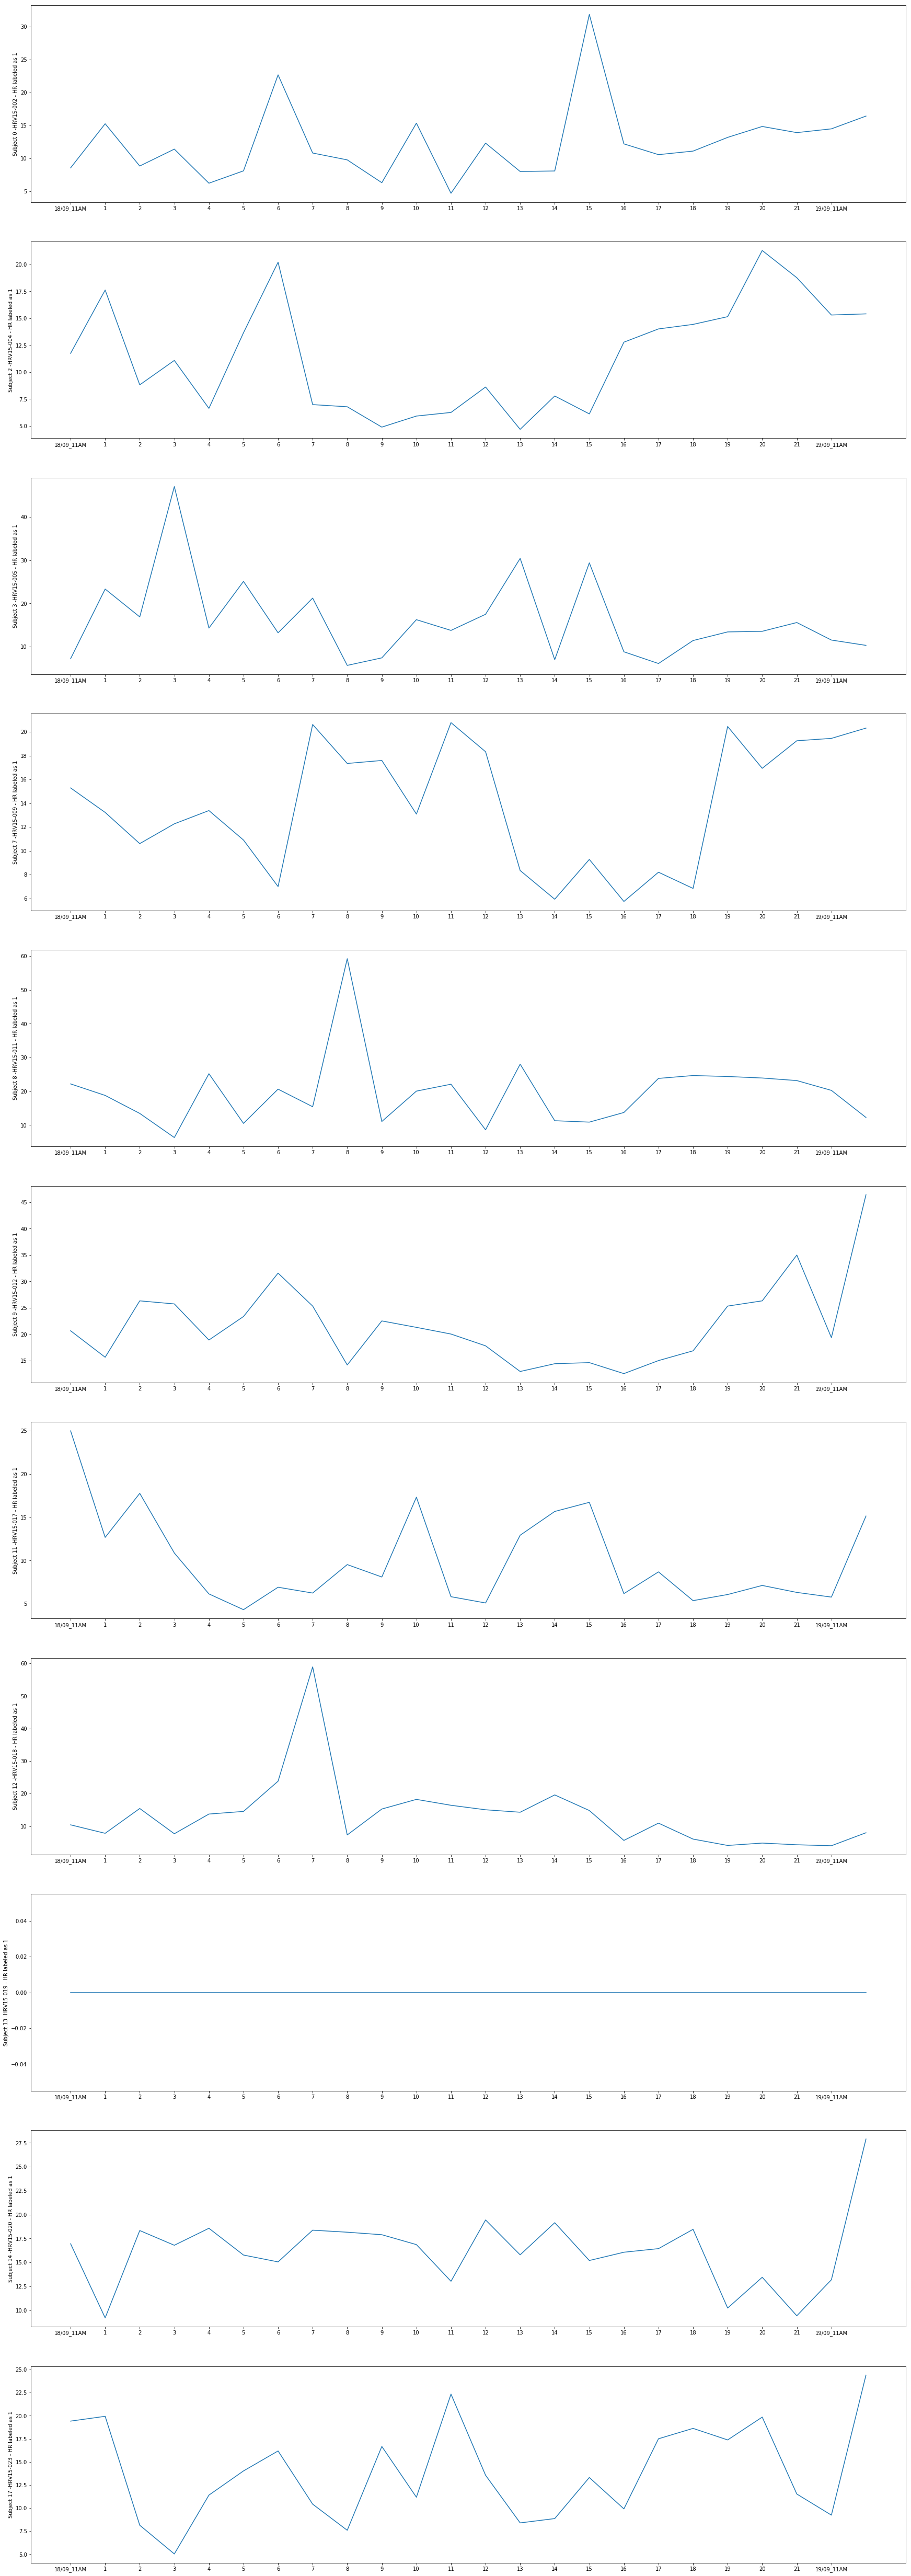

In [53]:
m = 'HR'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        
        plt.subplot(11,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        #plt.ylim(0,100)
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


In [54]:
Zxx.shape

(1501, 25)

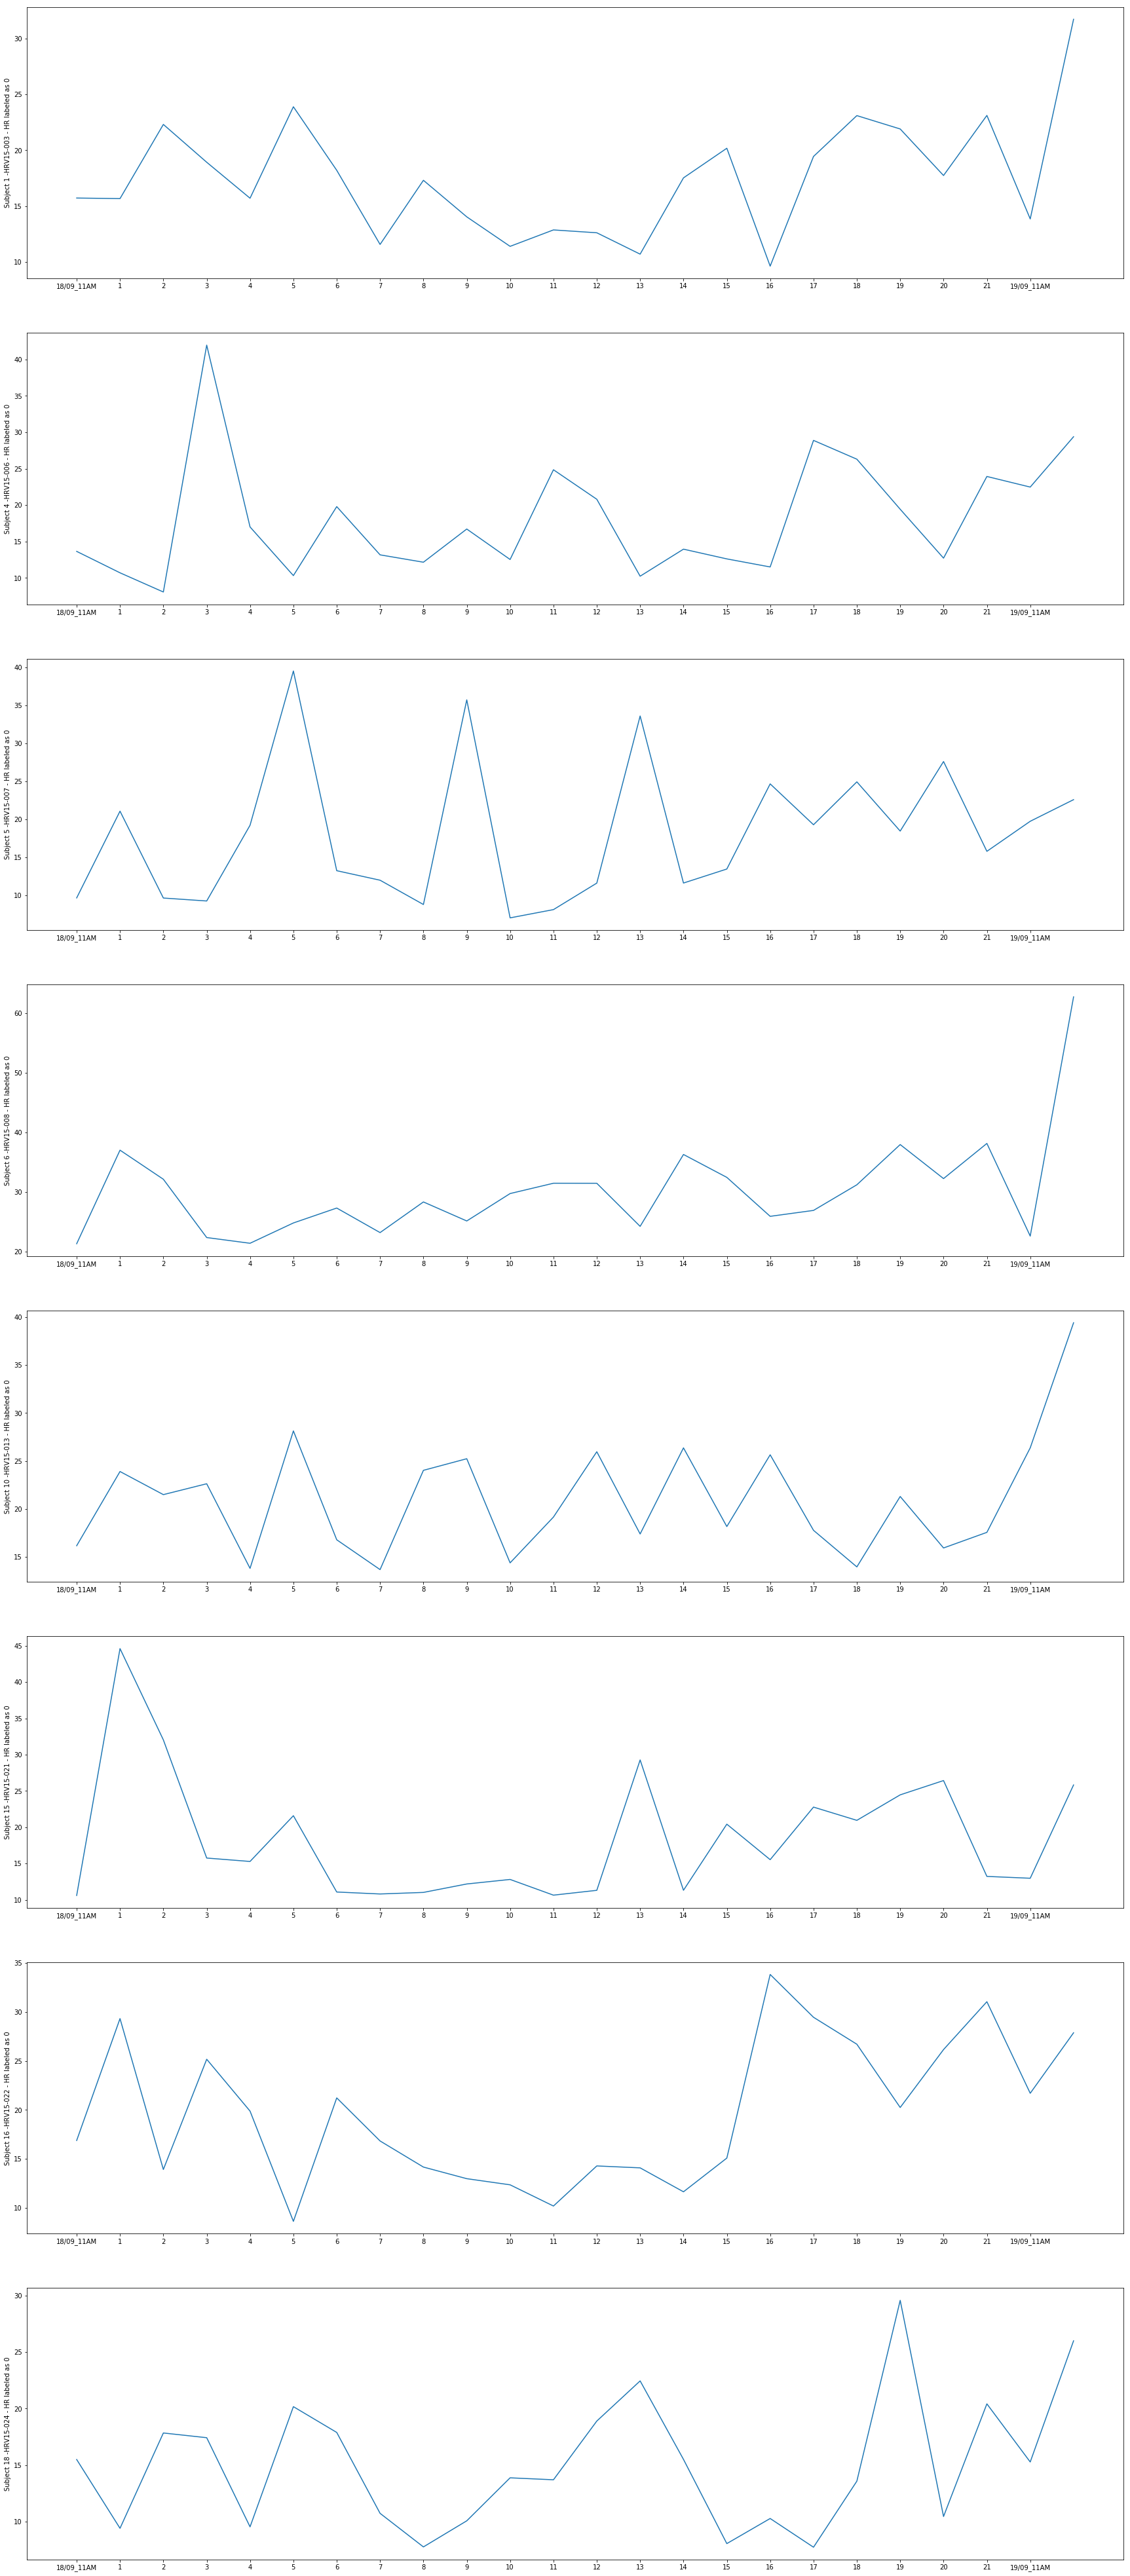

In [55]:
m = 'HR'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        
        plt.subplot(10,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


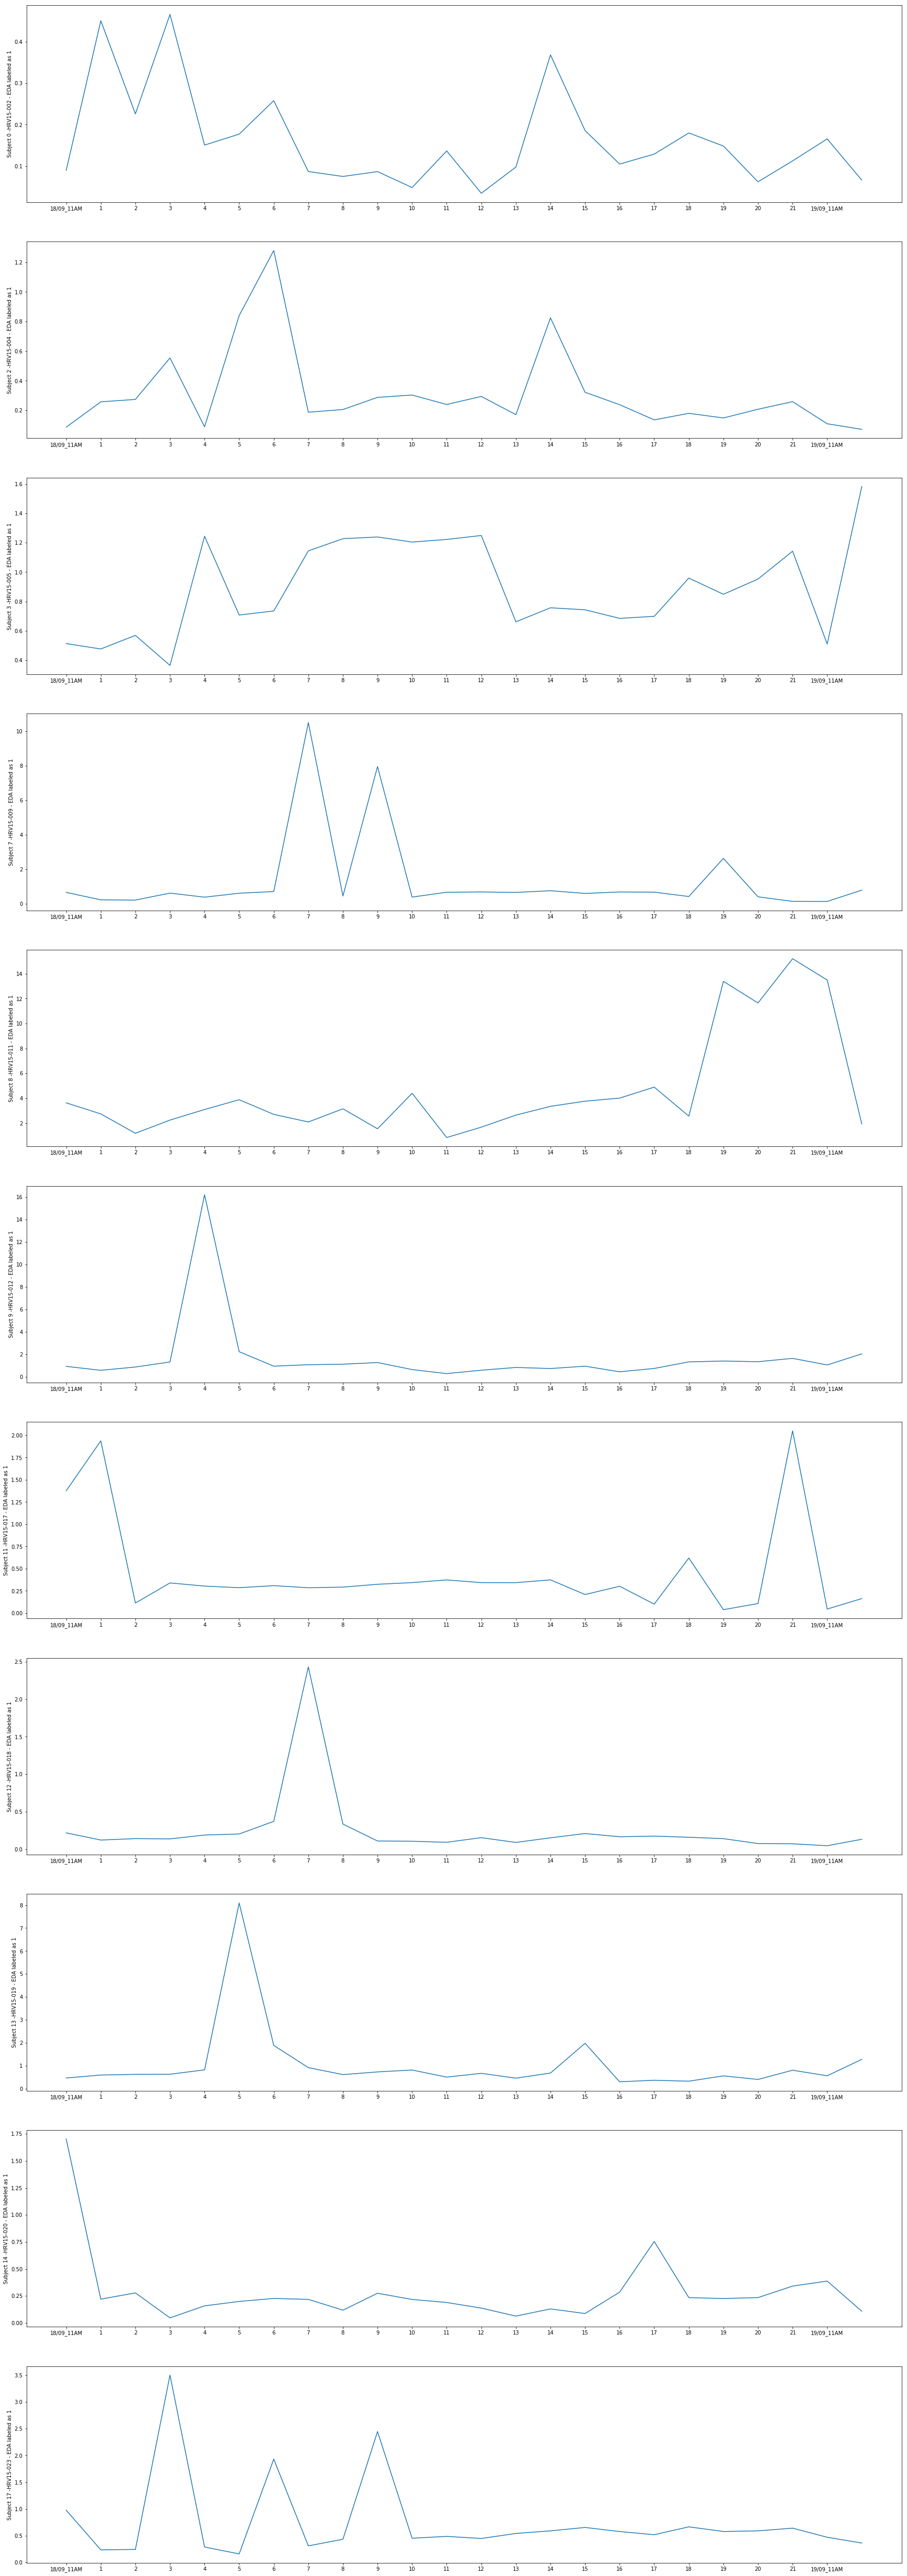

In [56]:
m = 'EDA'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        
        plt.subplot(11,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        #plt.ylim(0,100)
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


In [57]:
m

'EDA'

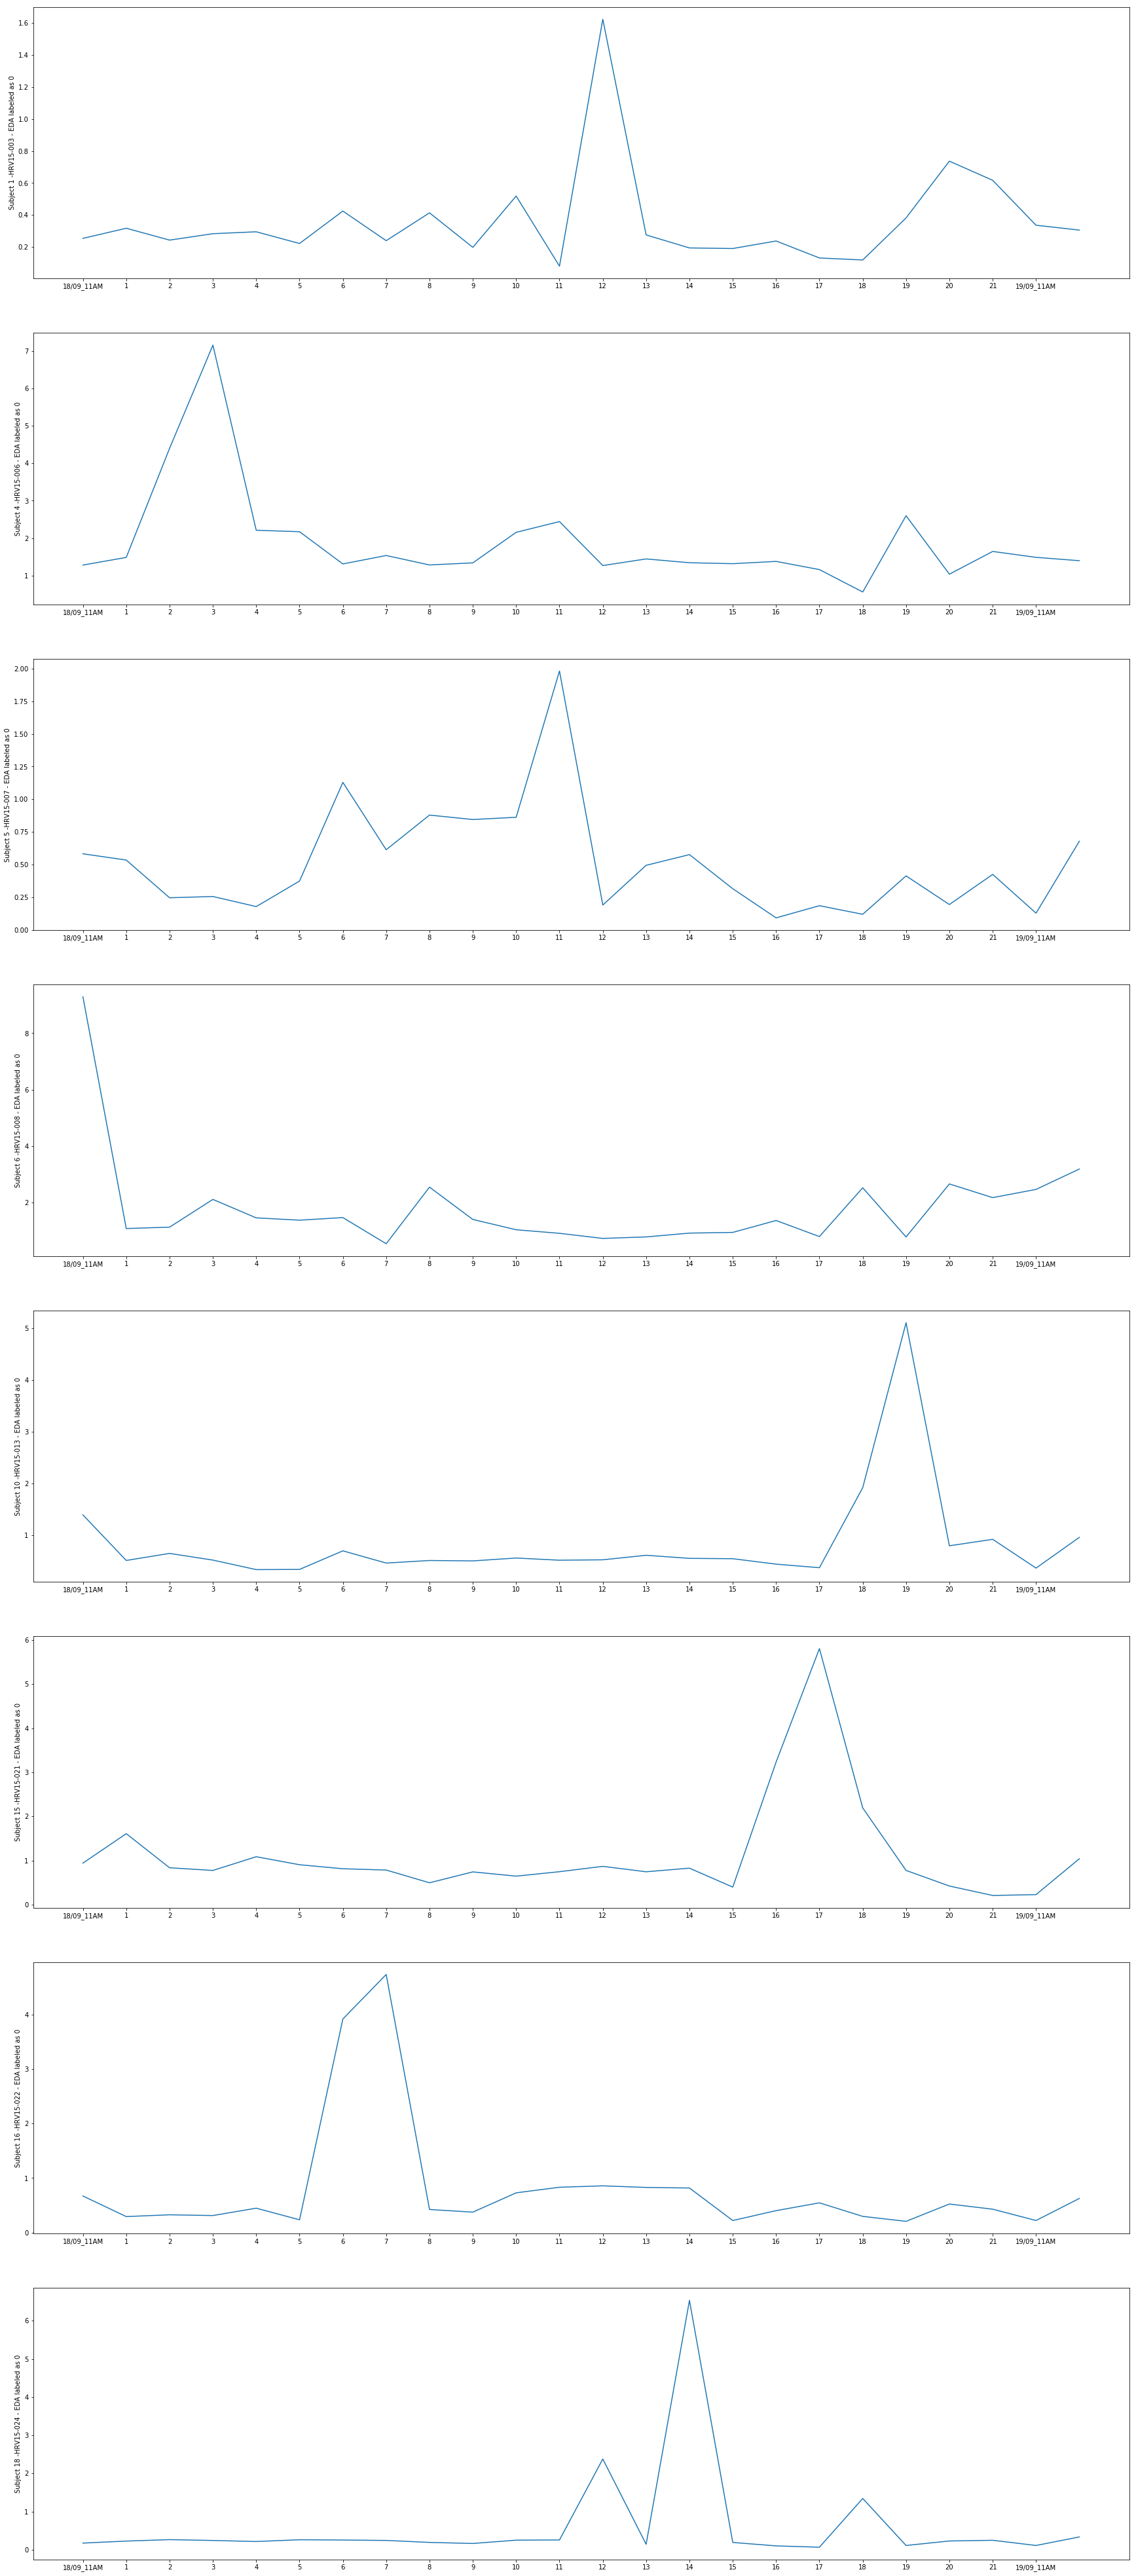

In [58]:
m = 'EDA'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        
        plt.subplot(10,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        #plt.ylim(0,100)
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


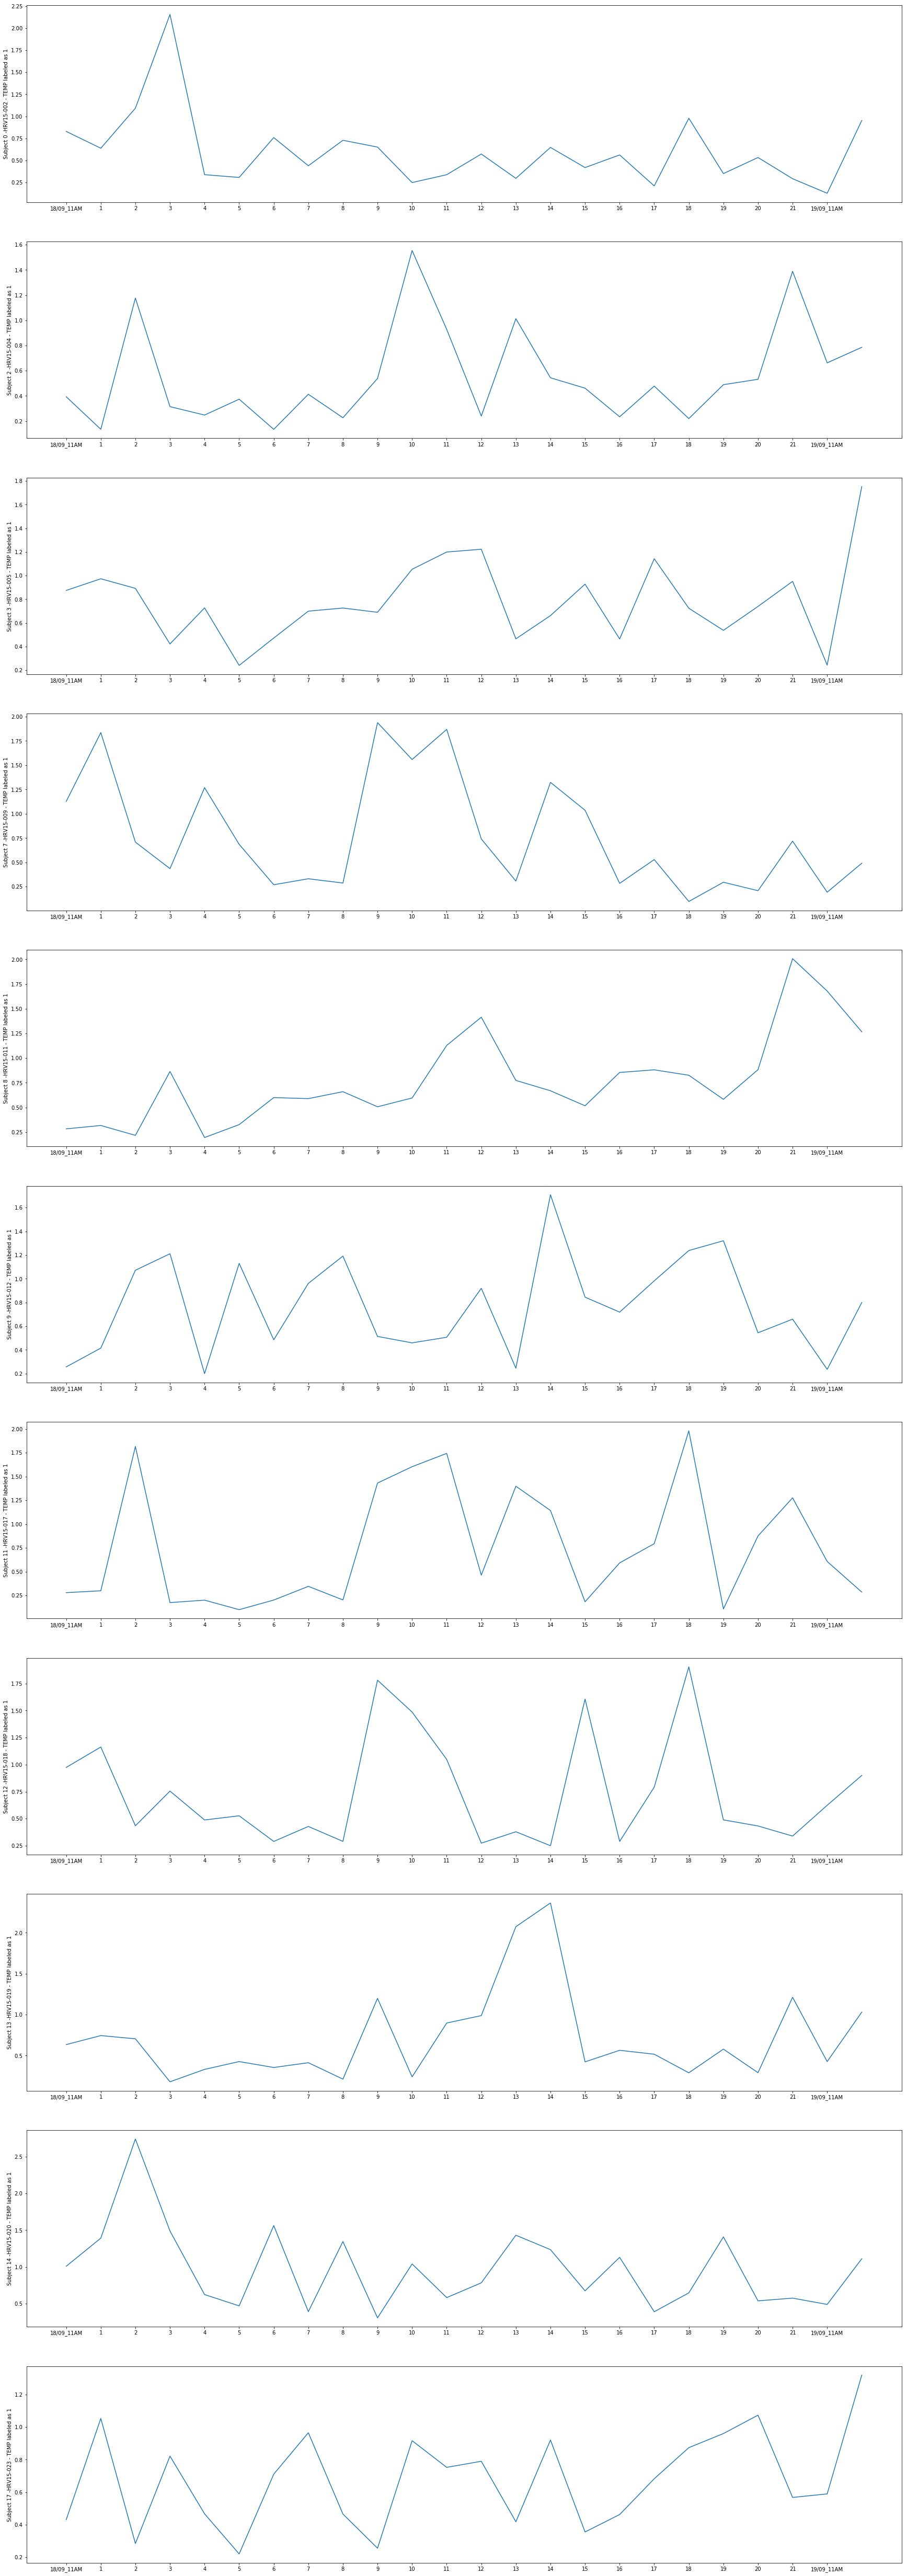

In [59]:
m = 'TEMP'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        
        plt.subplot(11,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        #plt.ylim(0,100)
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


In [60]:
m

'TEMP'

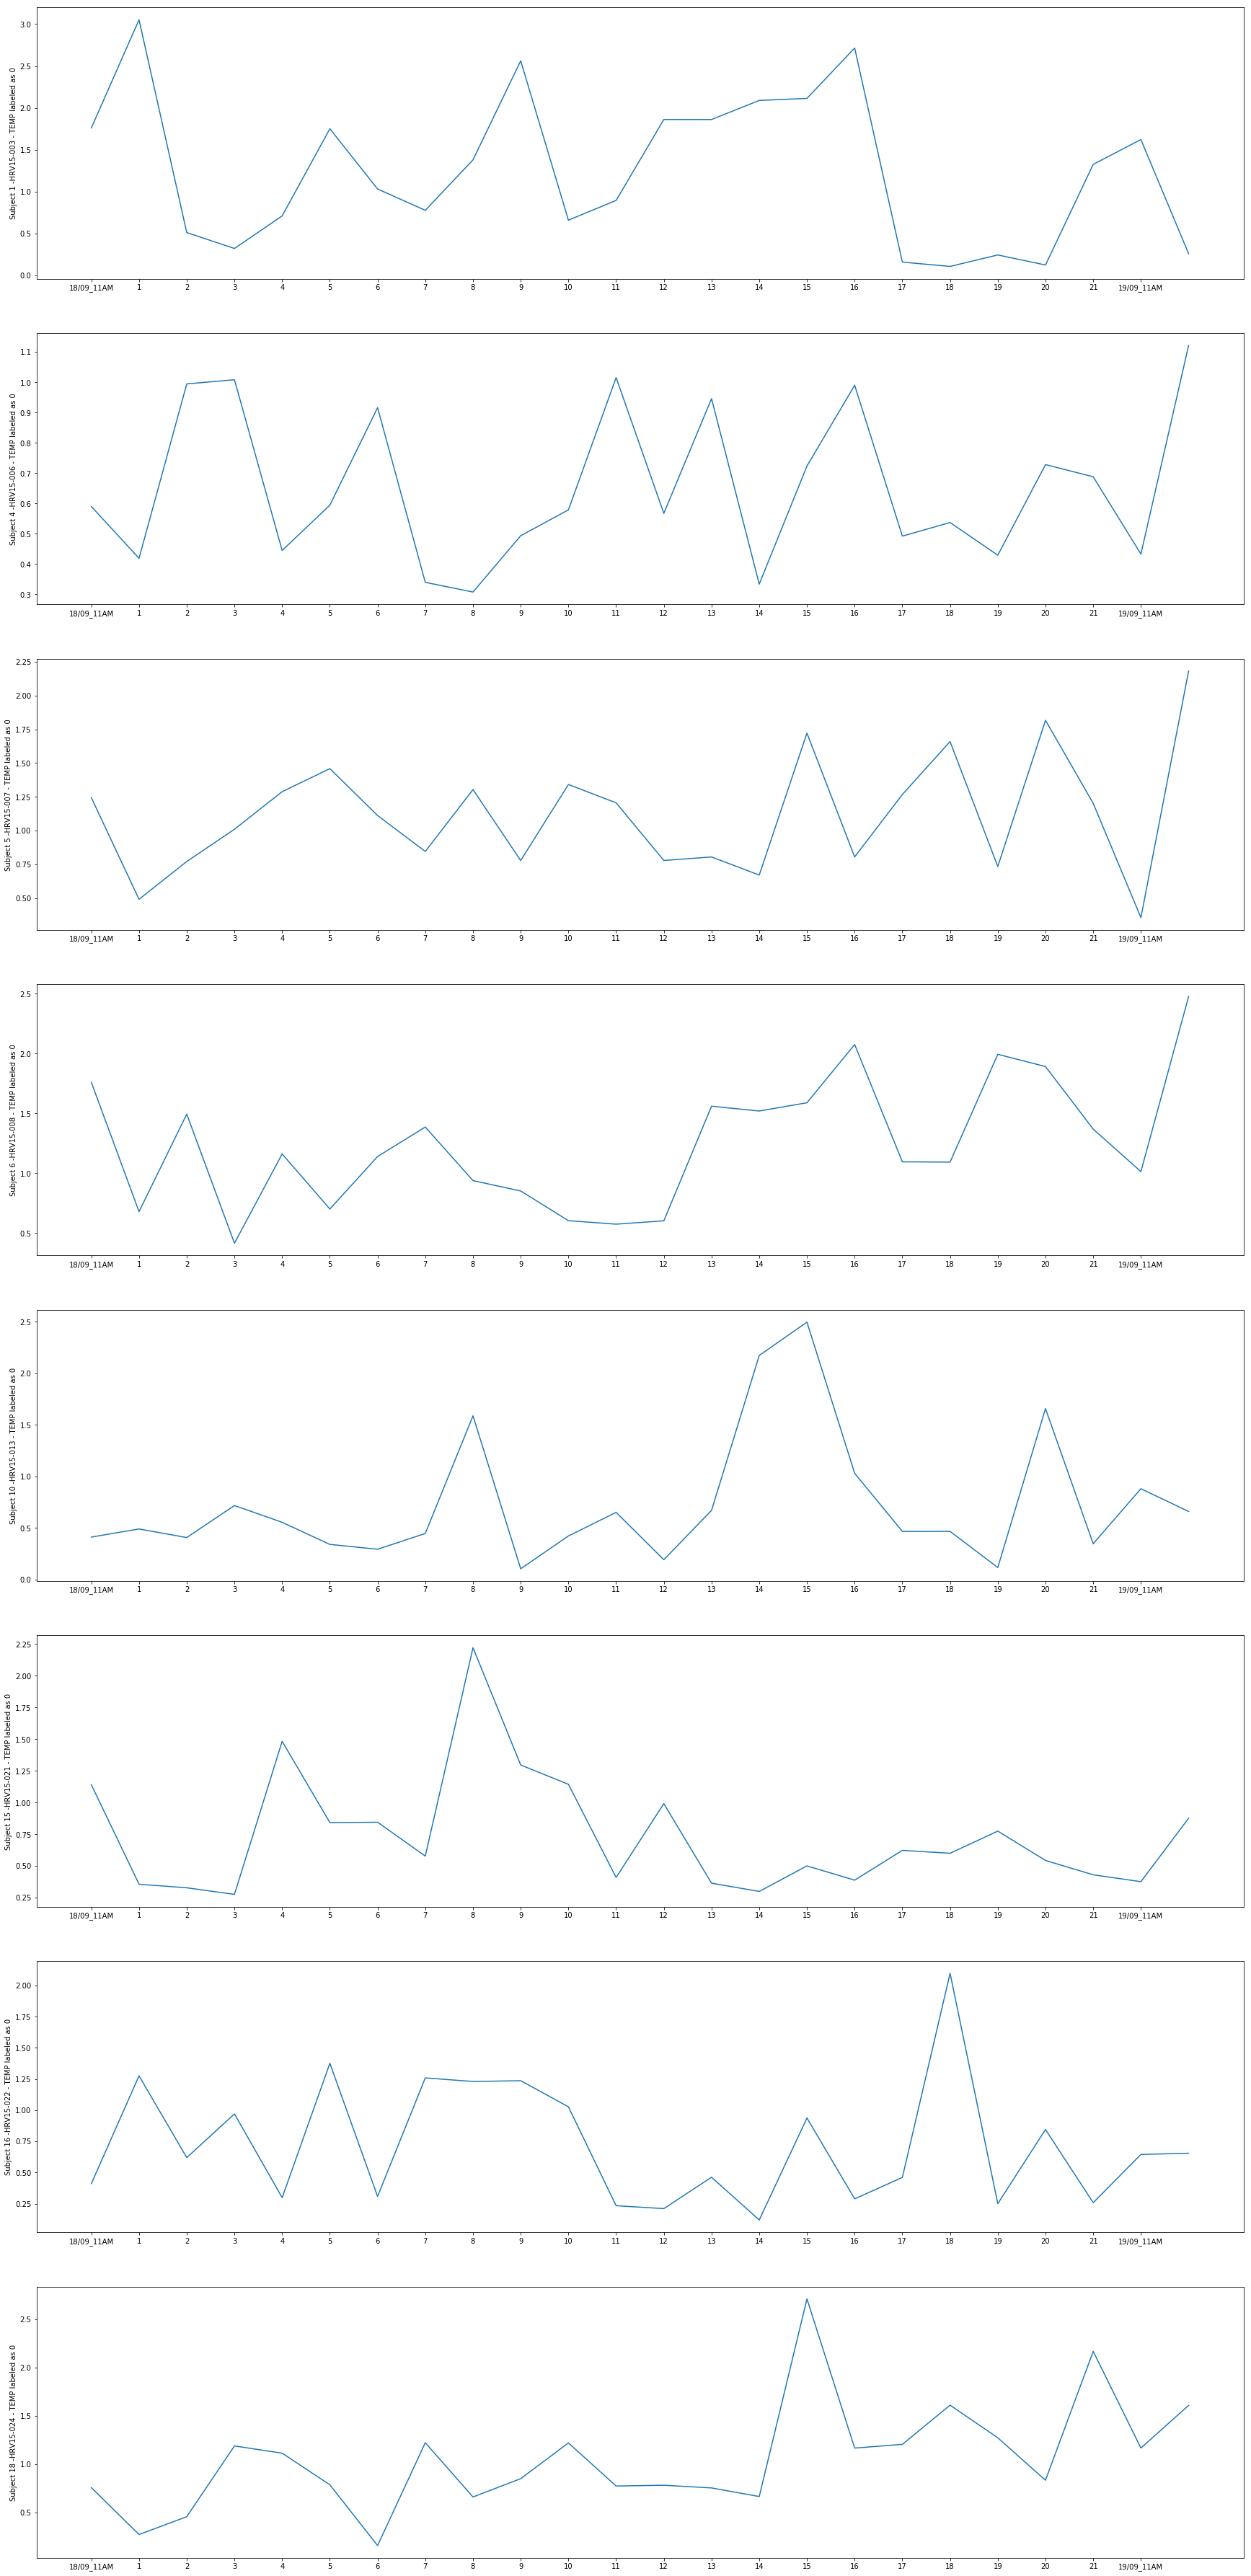

In [61]:
m = 'TEMP'
plt.figure(figsize=(30,90)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        
        plt.subplot(11,1,n)
        plt.plot(dtwlist[i][m])
        plt.ylabel(('Subject %d -%s - %s labeled as %d' % (i,names[i],m,label[i])))
        #plt.ylim(0,100)
        plt.xticks(np.arange(len(date)),date)
        
        n += 1


In [62]:
m

'TEMP'

0.759460963019
0.061493767664
0.188319209842
0.282709870744
0.379144326099
0.206798538959
0.239416886711
0.306321107456
0.169065944312
0.146739040434
0.11382864763
0.324491988069
0.197823035155
0.156747262179
0.375946352021
0.247064226246
0.295441657241
0.291989264069
0.0831766435668
0.759460963019
0.061493767664
0.188319209842
0.282709870744
0.379144326099
0.206798538959
0.239416886711
0.306321107456


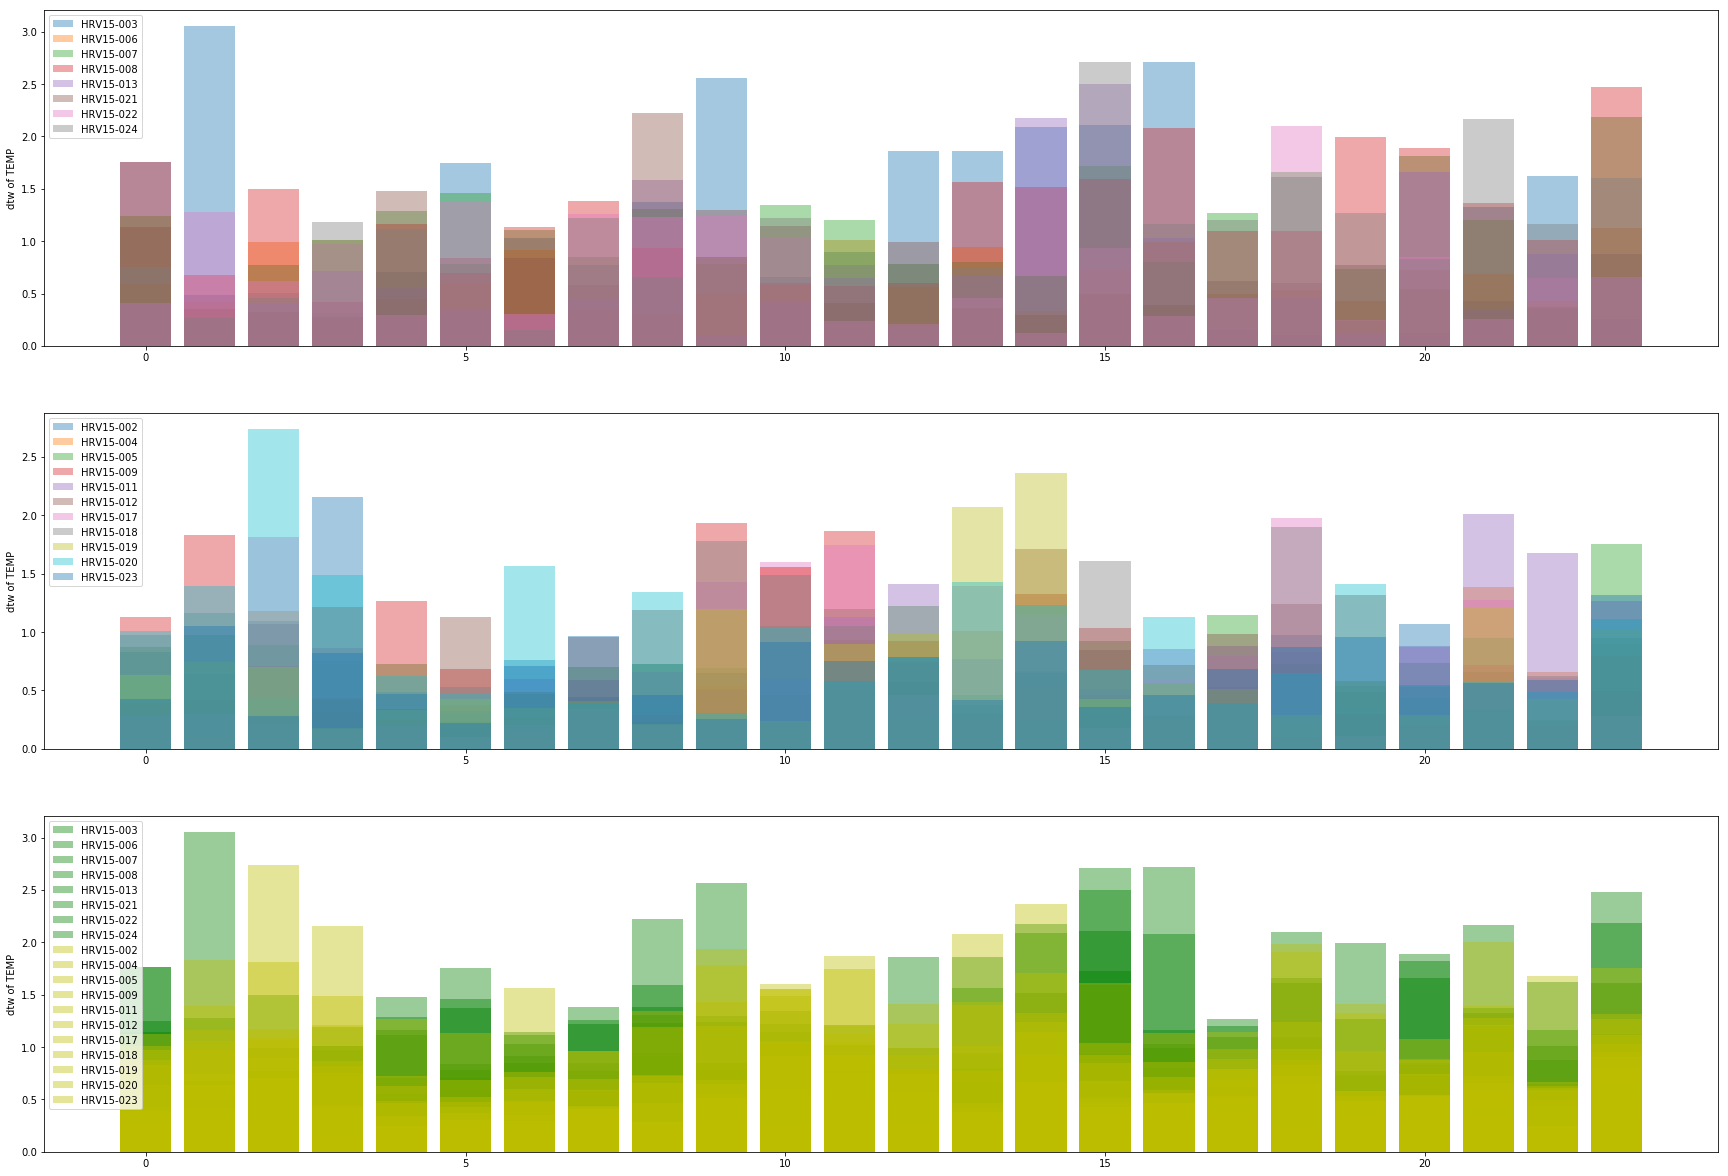

In [63]:
d = {}
m = 'TEMP'
plt.figure(figsize=(30,21))
plt.subplot(311)
n = 1
label1 = {}
label0 = {}

for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label0[names[i]] = np.var(dtwlist[i][m])
        plt.ylabel('dtw of %s'%m)
        
        n += 1
plt.legend()


plt.subplot(312)
#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label1[names[i]] = np.var(dtwlist[i][m])
        plt.ylabel('dtw of %s'%m)
        n += 1
        
d[m] = {'label0':label0, 'label1':label1}
plt.legend()

plt.subplot(313)
n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,color='g',label = names[i])
        print (np.var(dtwlist[i][m]))
        plt.ylabel('dtw of %s'%m)
       
        
        n += 1
        
#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],color='y',alpha=0.4,label = names[i])
        plt.ylabel('dtw of %s'%m)
        #print (np.var(dtwlist[i][m]))
       
        
        n += 1
        
plt.legend()



In [64]:
m

'TEMP'

/Users/sunyuting/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


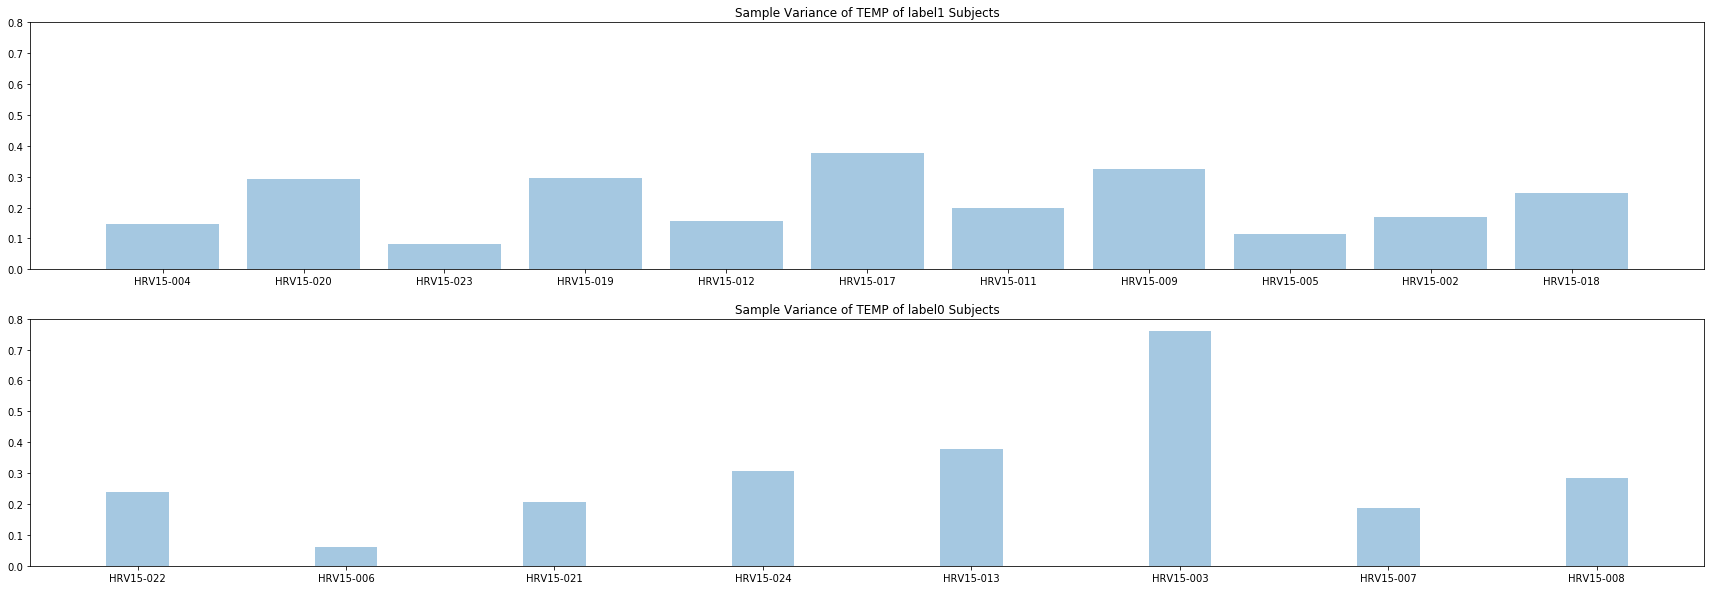

In [65]:
s = 'label1'
m = 'TEMP'

plt.figure(figsize=(30,10)) 
plt.subplot(211)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4)
plt.xticks(pos,d[m][s].keys())
plt.ylim(0,0.8)

plt.legend()


s = 'label0'
plt.subplot(212)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4,width=.3)
plt.xticks(pos,d[m][s].keys())
plt.ylim(0,0.8)
plt.legend()

In [66]:
m

'TEMP'

0.0919141921581
1.73409321017
0.169587304819
2.94863615832
0.911625059184
1.34340476558
1.18583398038
1.76299531092
0.0132222857388
0.0786181424856
0.0991738739101
5.99704592315
16.8578099237
9.37897686327
0.279085475918
0.21227831748
2.3351189104
0.106177145767
0.583077811128
0.0919141921581
1.73409321017
0.169587304819
2.94863615832
0.911625059184
1.34340476558
1.18583398038
1.76299531092


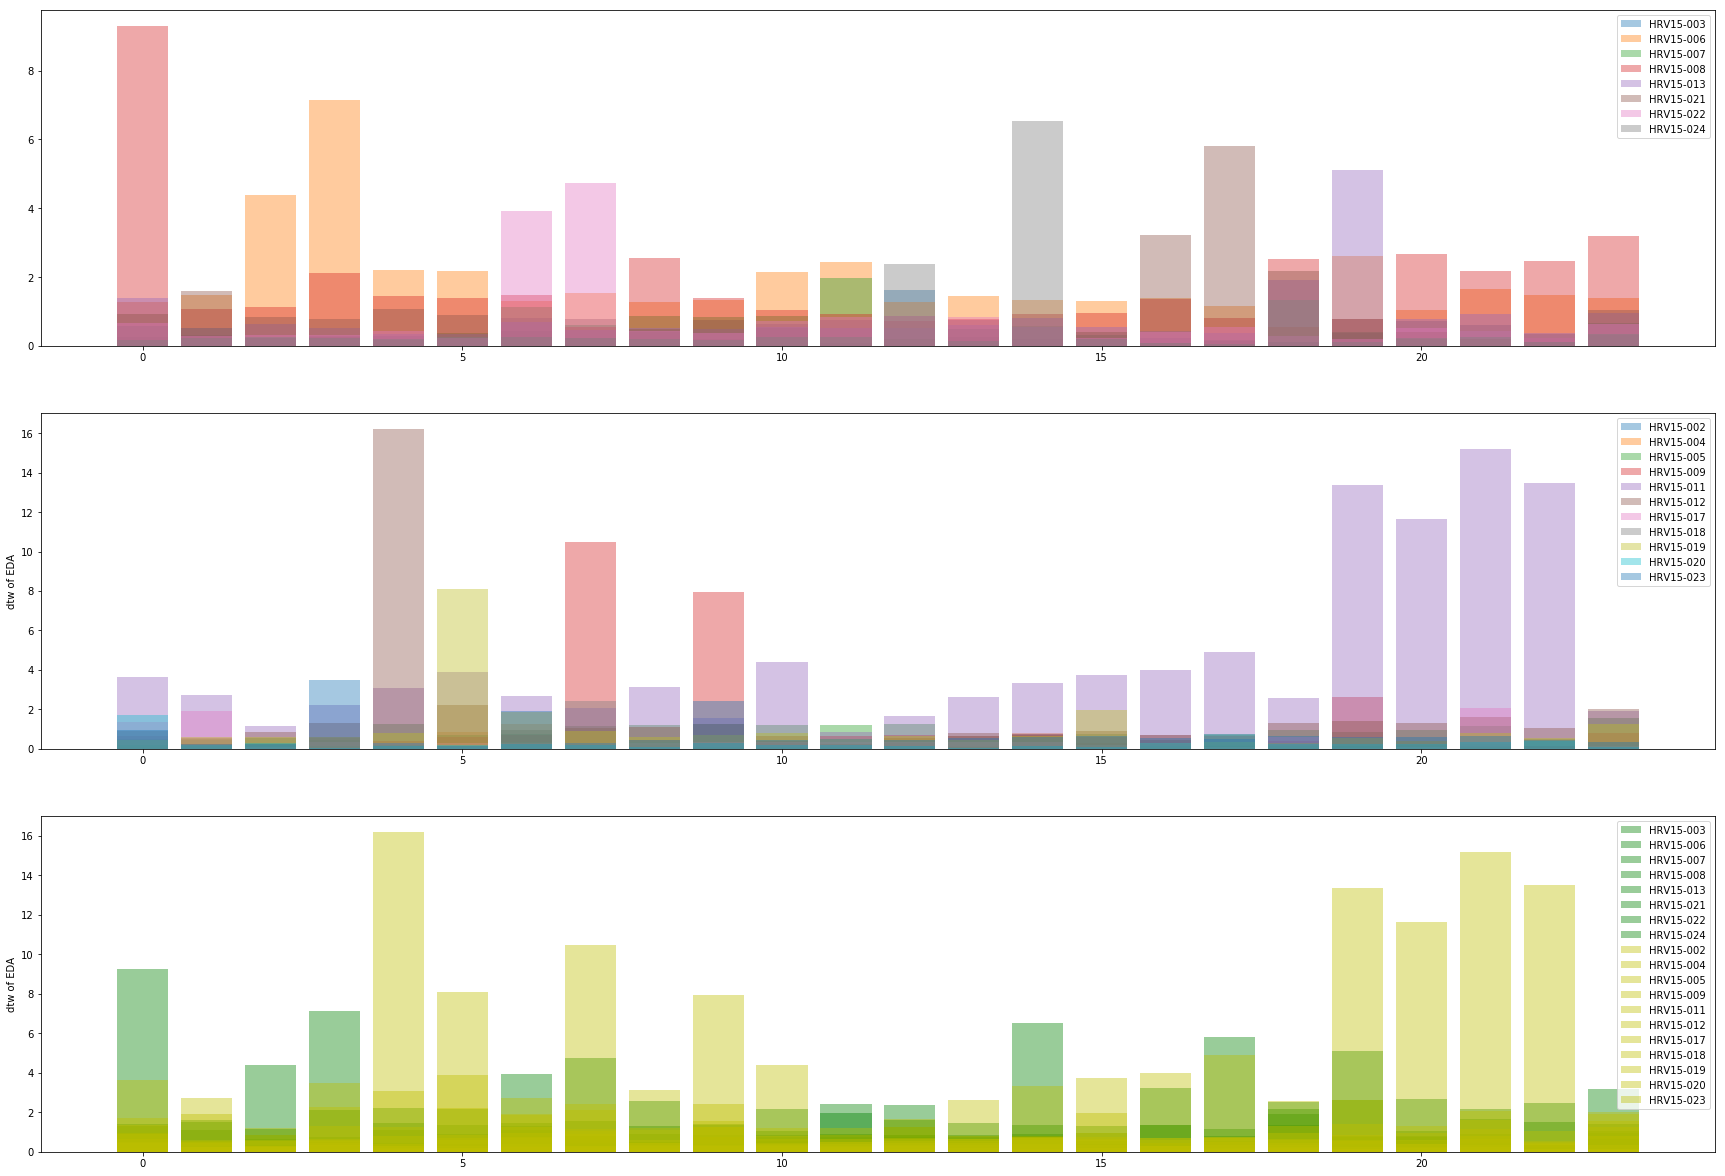

In [67]:
d = {}
m = 'EDA'
plt.figure(figsize=(30,21))
plt.subplot(311)
n = 1
label1 = {}
label0 = {}

for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label0[names[i]] = np.var(dtwlist[i][m])
       
        
        n += 1
plt.legend()


#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
plt.subplot(312)

for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label1[names[i]] = np.var(dtwlist[i][m])
        plt.ylabel('dtw of %s'%m)
        n += 1
        
d[m] = {'label0':label0, 'label1':label1}
plt.legend()

plt.subplot(313)
n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],color='g',alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        plt.ylabel('dtw of %s'%m)
        
        n += 1
        
#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],color='y',alpha=0.4,label = names[i])
        #print (np.var(dtwlist[i][m]))
        plt.ylabel('dtw of %s'%m)
        
        n += 1
        
plt.legend()



In [68]:
m

'EDA'

/Users/sunyuting/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


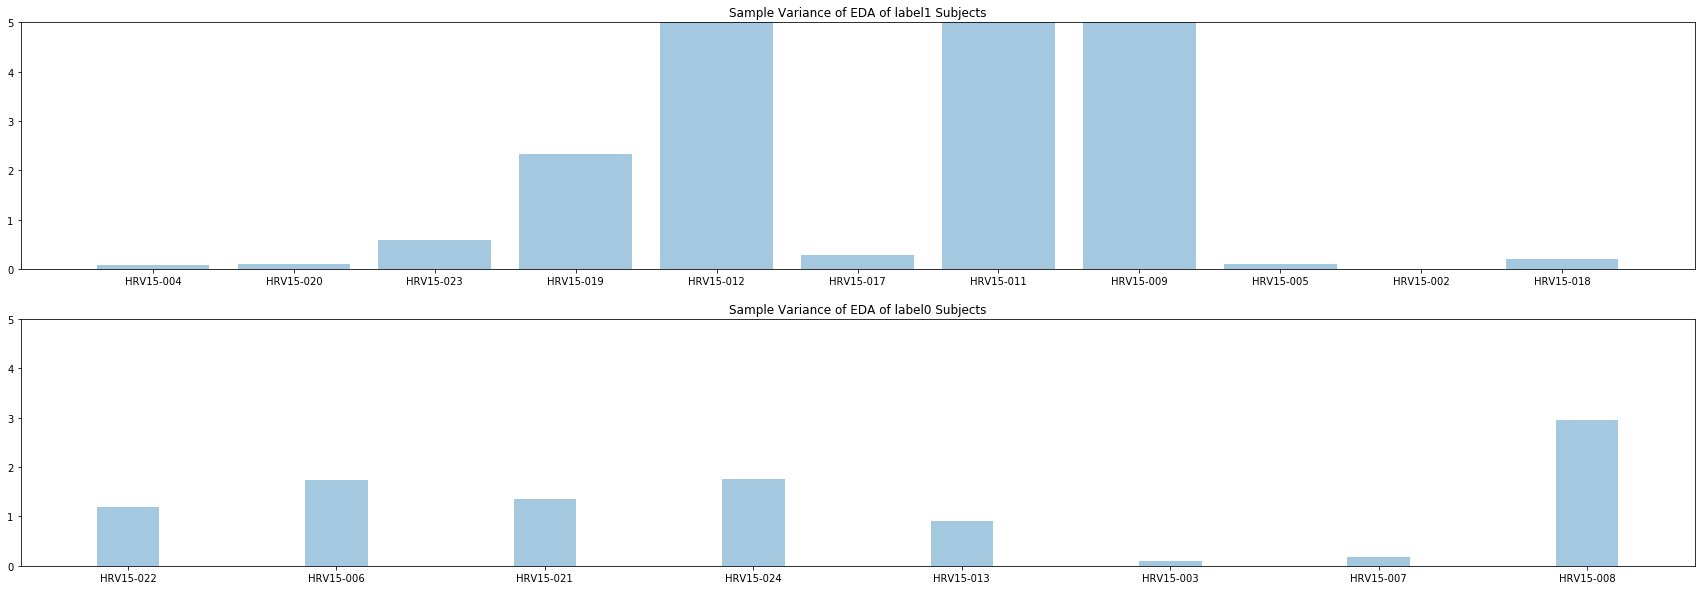

In [69]:
m = 'EDA'
s = 'label1'
plt.figure(figsize=(30,10)) 
plt.subplot(211)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4)
plt.xticks(pos,d[m][s].keys())
plt.ylim(0,5)

plt.legend()

s = 'label0'
plt.subplot(212)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4,width=.3)
plt.xticks(pos,d[m][s].keys())
plt.ylim(0,5)
plt.legend()

In [70]:
m

'EDA'

26.0756462412
62.6184933411
80.0108297092
72.5933800773
35.1665017247
71.9020234525
51.8933306493
32.8285525555
31.8090578342
25.0008033465
87.8329215027
26.1874039918
105.319322855
59.659735074
27.8454852574
119.089290174
0.0
14.3273432889
25.8380994266
26.0756462412
62.6184933411
80.0108297092
72.5933800773
35.1665017247
71.9020234525
51.8933306493
32.8285525555


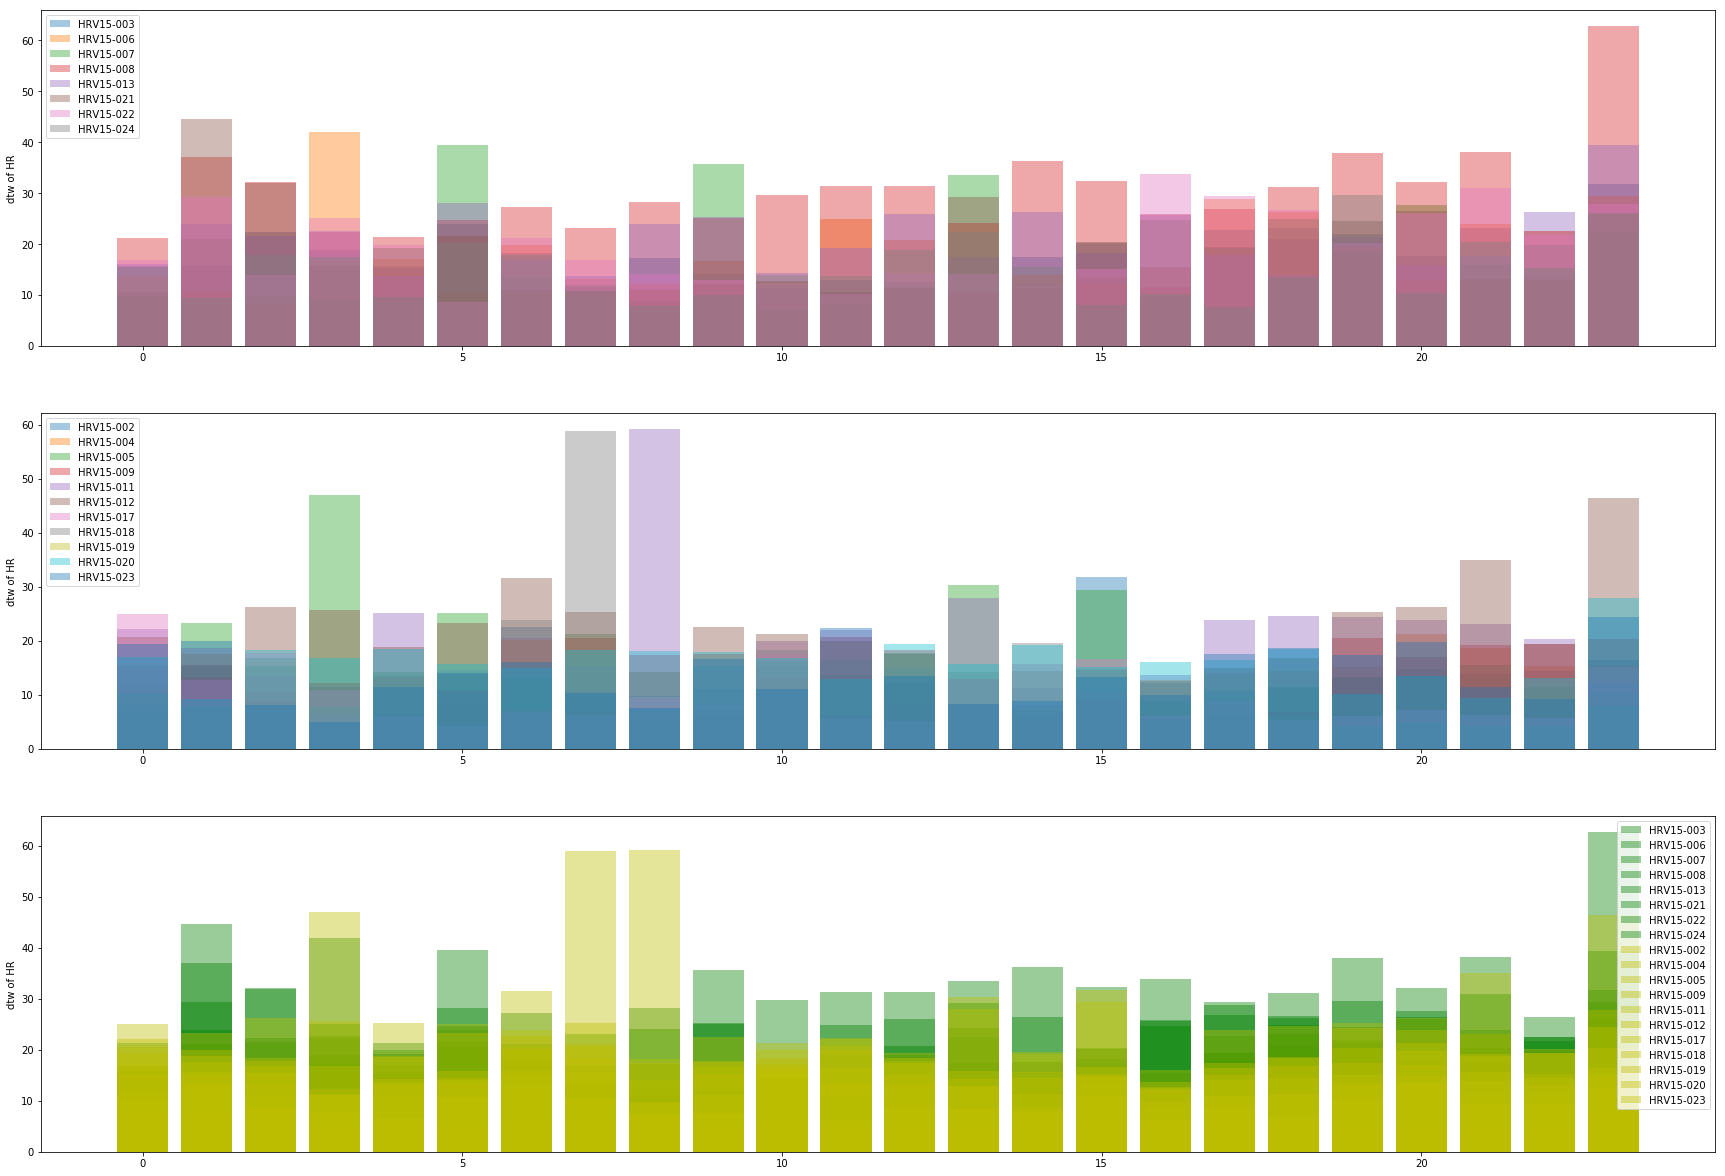

In [71]:
d = {}
m = 'HR'
plt.figure(figsize=(30,21)) 
n = 1
label1 = {}
label0 = {}
plt.subplot(311)
for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label0[names[i]] = np.var(dtwlist[i][m])
        plt.ylabel('dtw of %s'%m)
        
        n += 1
plt.legend()


#plt.figure(figsize=(30,5)) 
plt.subplot(312)

#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        label1[names[i]] = np.var(dtwlist[i][m])
        plt.ylabel('dtw of %s'%m)
        n += 1
        
d[m] = {'label0':label0, 'label1':label1}
plt.legend()

#plt.figure(figsize=(30,5)) 
plt.subplot(313)

n = 1
for i in range(effective_subject_size):
    if label[i] == 0:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],color='g',alpha=0.4,label = names[i])
        print (np.var(dtwlist[i][m]))
        plt.ylabel('dtw of %s'%m)
        
        n += 1
        
#m = 'TEMP'
#plt.figure(figsize=(30,5)) 
n = 1
for i in range(effective_subject_size):
    if label[i] == 1:
        pos = np.arange(len(dtwlist[i][m]))
        plt.bar(pos,dtwlist[i][m],color='y',alpha=0.4,label = names[i])
        #print (np.var(dtwlist[i][m]))
        plt.ylabel('dtw of %s'%m)
        
        n += 1
        
plt.legend()



In [72]:
64000/3600

17.77777777777778

/Users/sunyuting/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


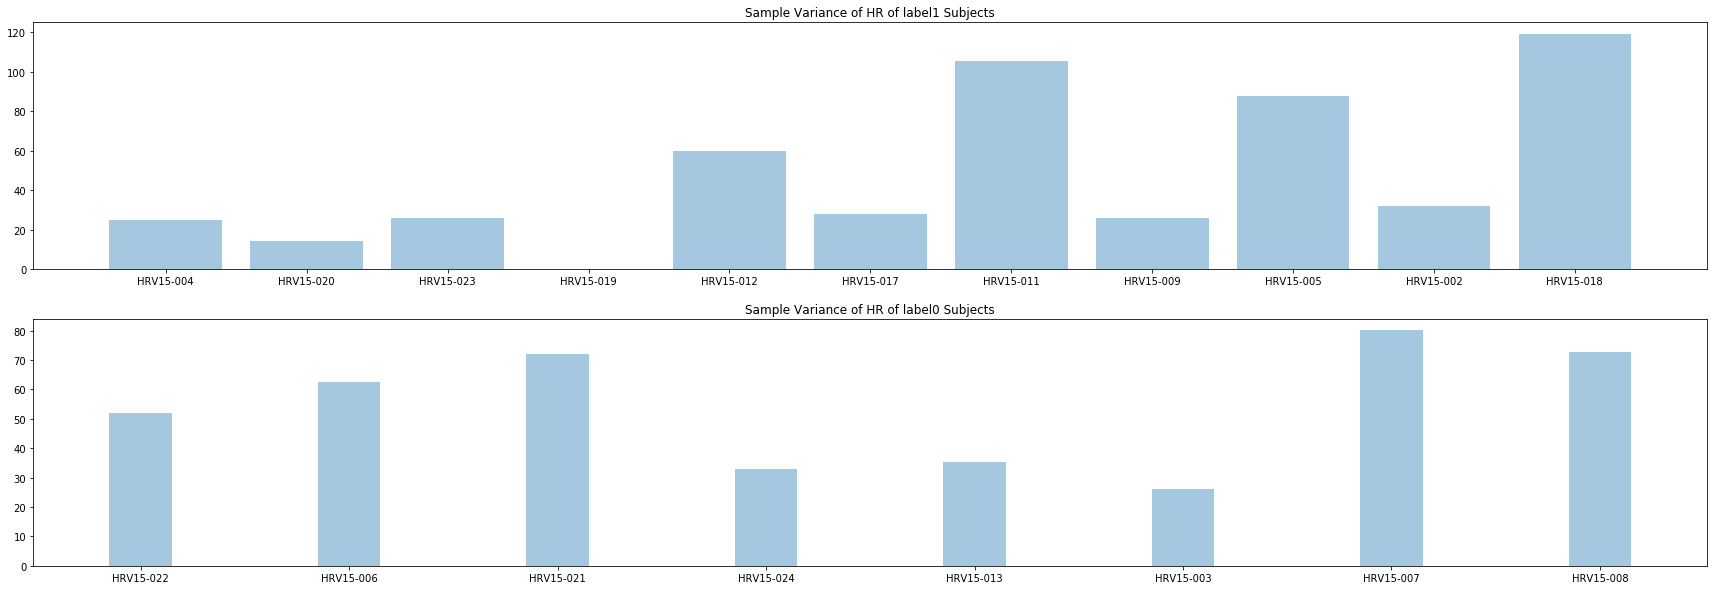

In [73]:
s = 'label1'
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4)
plt.xticks(pos,d[m][s].keys())
#plt.ylim(0,1500)

plt.legend()

s = 'label0'
plt.subplot(212)
plt.title('Sample Variance of %s of %s Subjects'%(m,s))
pos = np.arange(len(d[m][s].values()))
plt.bar(pos,d[m][s].values(),alpha=0.4,width=.3)
plt.xticks(pos,d[m][s].keys())
#plt.ylim(0,1500)
plt.legend()

# PCA RNA

In [75]:
RNA = pickle.load(open("RNA_proc/rna_in", "rb" ))
input_x = np.zeros((19,24))
for i in range(len(subjectlist)):
    input_x[i,:24] = dtwlist[i]['HR']
#     input_x[i,24:48] = dtwlist[i]['EDA']
#     input_x[i,48:72] = dtwlist[i]['TEMP']
#     input_x[i,72:96] = RNA[i]
   
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import neighbors
X = input_x
y = np.asanyarray(label)
loo = LeaveOneOut()
loo.get_n_splits(X)



X = input_x
y = np.asanyarray(label)
loo = LeaveOneOut()
loo.get_n_splits(X)

from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
pca.fit(X)

pca.n_components = 10
X_reduced = pca.fit_transform(X)
X_reduced.shape

test_sub = []
pred = []
truelabel = []
print(loo)
count = 0
match = []
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])
    test_sub.append(names[test_index])
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state = 1)
    truelabel.append(int(y_test[0]))
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    pred.append(int(Y_predict[0]))

    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
        match.append(True)
    else:
        match.append(False)
print (count/(len(subjectlist)))



LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 0.] [ 0.]
test_sub HRV15-004
[ 1.] [ 1.]
test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 1.] [ 0.]
test_sub HRV15-007
[ 0.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009
[ 1.] [ 1.]
test_sub HRV15-011
[ 0.] [ 1.]
test_sub HRV15-012
[ 0.] [ 1.]
test_sub HRV15-013
[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] 

/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 1.] [ 1.]
test_sub HRV15-020
[ 1.] [ 1.]
test_sub HRV15-021
[ 0.] [ 0.]
test_sub HRV15-022
[ 0.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 1.] [ 0.]
0.7368421052631579


In [76]:
expri = pd.DataFrame()
expri['Subject_ID'] = test_sub
expri['Prediction'] = pred
expri['True_Label'] = truelabel
expri['Match'] = match

expri.to_csv('pca_only_rna.csv')

In [ ]:
y = np.asanyarray(label)
y

In [78]:
RNA = pickle.load(open("RNA_proc/rna_in", "rb" ))
input_x = np.zeros((19,96))
for i in range(len(subjectlist)):
    input_x[i,:24] = dtwlist[i]['HR']
    input_x[i,24:48] = dtwlist[i]['EDA']
    input_x[i,48:72] = dtwlist[i]['TEMP']
    input_x[i,72:96] = RNA[i]

X = input_x
y = np.asanyarray(label)
loo = LeaveOneOut()
loo.get_n_splits(X)



X = input_x
y = np.asanyarray(label)
loo = LeaveOneOut()
loo.get_n_splits(X)

from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
pca.fit(X)

pca.n_components = 10
X_reduced = pca.fit_transform(X)
X_reduced.shape

test_sub = []
pred = []
truelabel = []
print(loo)
count = 0
match = []
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])
    test_sub.append(names[test_index])
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state = 1)
    truelabel.append(int(y_test[0]))
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    pred.append(int(Y_predict[0]))

    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
        match.append(True)
    else:
        match.append(False)
print (count/(len(subjectlist)))



LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 0.] [ 0.]
test_sub HRV15-004
[ 1.] [ 1.]
test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 1.] [ 0.]
test_sub HRV15-007
[ 0.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009
[ 1.] [ 1.]
test_sub HRV15-011
[ 1.] [ 1.]
test_sub HRV15-012
[ 0.] [ 1.]
test_sub HRV15-013


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] [ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 1.] [ 1.]
test_sub HRV15-020
[ 1.] [ 1.]
test_sub HRV15-021
[ 0.] [ 0.]
test_sub HRV15-022
[ 0.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 1.] [ 0.]
0.7894736842105263


In [79]:
expri = pd.DataFrame()
expri['Subject_ID'] = test_sub
expri['Prediction'] = pred
expri['True_Label'] = truelabel
expri['Match'] = match

expri.to_csv('pca_full_rna.csv')

# RNA only no PCA

In [80]:
RNA = pickle.load(open("RNA_proc/rna_in", "rb" ))
input_x = np.zeros((19,24))
for i in range(len(subjectlist)):
    input_x[i,:24] = dtwlist[i]['HR']
#     input_x[i,24:48] = dtwlist[i]['EDA']
#     input_x[i,48:72] = dtwlist[i]['TEMP']
#     input_x[i,72:96] = RNA[i]
    
X = input_x

test_sub = []
pred = []
truelabel = []
print(loo)
count = 0
match = []
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])
    test_sub.append(names[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state=1)
    truelabel.append(int(y_test[0]))
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    pred.append(int(Y_predict[0]))

    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
        match.append(True)
    else:
        match.append(False)
print (count/(len(subjectlist)))

LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 1.] [ 0.]
test_sub HRV15-004
[ 0.] [ 1.]
test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 0.] [ 0.]
test_sub HRV15-007
[ 1.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009
[ 1.] [ 1.]
test_sub HRV15-011


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 1.] [ 1.]
test_sub HRV15-012
[ 1.] [ 1.]
test_sub HRV15-013
[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] [ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 0.] [ 1.]
test_sub HRV15-020
[ 1.] [ 1.]
test_sub HRV15-021
[ 0.] [ 0.]
test_sub HRV15-022
[ 1.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 0.] [ 0.]
0.6842105263157895


In [81]:
expri = pd.DataFrame()
expri['Subject_ID'] = test_sub
expri['Prediction'] = pred
expri['True_Label'] = truelabel
expri['Match'] = match

expri.to_csv('only_rna.csv')

In [82]:
RNA = pickle.load(open("RNA_proc/rna_in", "rb" ))
input_x = np.zeros((19,96))
for i in range(len(subjectlist)):
    input_x[i,:24] = dtwlist[i]['HR']
    input_x[i,24:48] = dtwlist[i]['EDA']
    input_x[i,48:72] = dtwlist[i]['TEMP']
    input_x[i,72:96] = RNA[i]
    
X = input_x

test_sub = []
pred = []
truelabel = []
print(loo)
count = 0
match = []
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])
    test_sub.append(names[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state=1)
    truelabel.append(int(y_test[0]))
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    pred.append(int(Y_predict[0]))

    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
        match.append(True)
    else:
        match.append(False)
print (count/(len(subjectlist)))

LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 1.] [ 0.]
test_sub HRV15-004
[ 0.] [ 1.]


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 0.] [ 0.]
test_sub HRV15-007
[ 0.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009
[ 1.] [ 1.]
test_sub HRV15-011
[ 1.] [ 1.]
test_sub HRV15-012
[ 0.] [ 1.]
test_sub HRV15-013
[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] [ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 1.] [ 1.]
test_sub HRV15-020
[ 0.] [ 1.]
test_sub HRV15-021
[ 1.] [ 0.]
test_sub HRV15-022
[ 1.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 1.] [ 0.]
0.5789473684210527


In [83]:
expri = pd.DataFrame()
expri['Subject_ID'] = test_sub
expri['Prediction'] = pred
expri['True_Label'] = truelabel
expri['Match'] = match

expri.to_csv('full.csv')

In [117]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [118]:
print(pca.explained_variance_ratio_) 

[  4.46073996e-01   1.08717039e-01   9.67318140e-02   7.53663568e-02
   6.05327099e-02   4.81722795e-02   3.91443905e-02   2.82533938e-02
   2.13040105e-02   1.73785777e-02   1.45753511e-02   1.25838890e-02
   9.52640073e-03   6.50139137e-03   6.16971866e-03   3.88651506e-03
   3.08458888e-03   1.99757799e-03   2.36364311e-32]


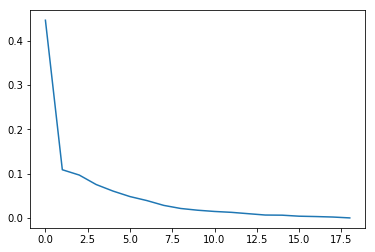

In [119]:
plt.plot(pca.explained_variance_ratio_)

In [120]:
pca.n_components = 10
X_reduced = pca.fit_transform(X)
X_reduced.shape


(19, 10)

In [157]:
RNA = pickle.load(open("RNA_proc/rna_in", "rb" ))
input_x = np.zeros((19,24))
for i in range(len(subjectlist)):
    input_x[i,:24] = dtwlist[i]['HR']
#     input_x[i,24:48] = dtwlist[i]['EDA']
#     input_x[i,48:72] = dtwlist[i]['TEMP']
#     input_x[i,72:96] = RNA[i]
    
X = input_x

test_sub = []
pred = []
truelabel = []
print(loo)
count = 0
match = []
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])
    test_sub.append(names[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state=1)
    pred.append(int(Y_predict[0]))
    truelabel.append(int(y_test[0]))
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
        match.append(True)
    else:
        match.append(False)
print (count/(len(subjectlist)))

LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 1.] [ 0.]
test_sub HRV15-004
[ 0.] [ 1.]
test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 0.] [ 0.]
test_sub HRV15-007
[ 1.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 1.] [ 1.]
test_sub HRV15-011
[ 1.] [ 1.]
test_sub HRV15-012
[ 1.] [ 1.]
test_sub HRV15-013
[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] [ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 0.] [ 1.]
test_sub HRV15-020
[ 1.] [ 1.]
test_sub HRV15-021
[ 0.] [ 0.]
test_sub HRV15-022
[ 1.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 0.] [ 0.]
0.6842105263157895


In [155]:

from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import neighbors
X = X_reduced
y = np.asanyarray(label)
loo = LeaveOneOut()
loo.get_n_splits(X)

print(loo)
count = 0
for train_index, test_index in loo.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print (test_index)
    print ('test_sub',names[test_index])

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#   print(X_train, X_test, y_train, y_test)
    #clf = svm.SVC()
    
    #clf = neighbors.KNeighborsClassifier()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,random_state= 1)
                    
    clf.fit(X_train, y_train)  
    Y_predict = clf.predict(X_test)
    print (Y_predict,y_test)
    if Y_predict == y_test:
        count += 1
print (count/(len(subjectlist)))
print (count)

LeaveOneOut()
test_sub HRV15-002
[ 1.] [ 1.]
test_sub HRV15-003
[ 0.] [ 0.]
test_sub HRV15-004
[ 1.] [ 1.]
test_sub HRV15-005
[ 0.] [ 1.]
test_sub HRV15-006
[ 1.] [ 0.]
test_sub HRV15-007
[ 0.] [ 0.]
test_sub HRV15-008
[ 0.] [ 0.]
test_sub HRV15-009
[ 1.] [ 1.]
test_sub HRV15-011
[ 1.] [ 1.]
test_sub HRV15-012
[ 0.] [ 1.]
test_sub HRV15-013
[ 0.] [ 0.]
test_sub HRV15-017
[ 1.] [ 1.]
test_sub HRV15-018
[ 1.] [ 1.]
test_sub HRV15-019
[ 1.] [ 1.]
test_sub HRV15-020
[ 1.] [ 1.]
test_sub HRV15-021


/Users/sunyuting/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 0.] [ 0.]
test_sub HRV15-022
[ 0.] [ 0.]
test_sub HRV15-023
[ 1.] [ 1.]
test_sub HRV15-024
[ 1.] [ 0.]
0.7894736842105263
15
